# Tutorial: K562 HCT116 SP1 single-cell calling cards data. 

In this tutorial, we will analyze the binding of the transcription factor Sp1 in K562 and HCT116 cell lines. These data are generated using single-cell calling cards (scCCs). The data is from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037) and can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148448).

We will cover how to call TF peaks using a background file, annotate these peaks, compare them with Chip-seq reference data, and perform a differential peak analysis. 

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150

We start by reading the qbed datafile. In this file, each row represents a Sp1-directed insertion and columns indicate the chromosome, start point and end point, reads number, the direction and cell barcode of each insertion. For example, the first row tells us the first insertion is on Chromosome 1 in a TTAA site located at genomic coordinates 30116 to 30120. There are 12 reads supporting this insertion, which maps to the negative strand of the  genome. The cell barcode is CCCAATCCATCGGTTA-1. Note that the cell barcode allows us to connect this insertino to scRNA-seq data collected from the same cell.

Use ```cc.rd.read_qbed(filename)``` to read your own ccf data.

In [2]:
# read in experiement data
HCT116_SP1 = cc.datasets.SP1_K562HCT116_data(data = "HCT116_SP1_qbed")
HCT116_SP1

Chr     Start       End  Reads Direction            Barcodes
0      chr1     30116     30120      5         -  CCCAATCCATCGGTTA-1
1      chr1     34568     34572      3         -  CCTTCGAAGGGCTTCC-1
2      chr1     36736     36740     29         +  ACGAGCCGTATAGGTA-1
3      chr1     42447     42451      3         -  CTCTACGTCGGAGCAA-1
4      chr1     89697     89701    119         -  AGCTCTCGTTTGTTTC-1
...     ...       ...       ...    ...       ...                 ...
77205  chrY  25518788  25518792      2         +  TGGGCGTTCGAACGGA-1
77206  chrY  56987633  56987637     13         +  CAGTCCTAGGCACATG-1
77207  chrY  57080855  57080859     17         +  CGGAGCTCATCGACGC-1
77208  chrY  57080855  57080859      7         +  GTAACGTAGTTACGGG-1
77209  chrY  57080855  57080859      9         +  TCAGCAAGTTGAACTC-1

[77210 rows x 6 columns]

In [3]:
# read in backgound data 
HCT116_brd4 = cc.datasets.SP1_K562HCT116_data(data="HCT116_brd4_qbed")
HCT116_brd4 

Chr     Start       End  Reads Direction            Barcodes
0      chr1     89697     89701     14         +  TCTGAGACAATGGTCT-1
1      chr1     89697     89701      8         +  CAGCGACCAAATACAG-1
2      chr1    203932    203936     99         +  TTCTCCTTCTACTTAC-1
3      chr1    204063    204067      5         -  TGTTCCGGTGTAAGTA-1
4      chr1    204063    204067      7         -  CAAGATCTCGACCAGC-1
...     ...       ...       ...    ...       ...                 ...
37769  chrY  18037315  18037319      9         -  GCAGTTAAGATCTGAA-1
37770  chrY  24036504  24036508    168         +  GCAGTTAAGATCTGAA-1
37771  chrY  24036504  24036508    508         +  CATATGGCAGCCAGAA-1
37772  chrY  25633622  25633626     13         -  GCAGTTAAGATCTGAA-1
37773  chrY  25633622  25633626     32         -  CATATGGCAGCCAGAA-1

[37774 rows x 6 columns]

We first need to call peaks in order to find candidate SP1 binding sites. There are three different methods (*CCcaller, MACCS, Blockify*) available in Pycallingcards. Here, we will use ***MACCS*** to call peaks.  The appropriate reference genome for these data is *human*('hg38') . The *window_size* parameter is the most important parameter for *MACCS*, it is highly related to the length of a peak. A value of 500-3500 is recommended for most sequence-specific TFs. *step_size* is another important paramenter and it controls whether two nearby clusters of insertions are called as one peak or split into two peaks. 250-1000 is good for *step_size*. *pvalue_cutoffTTAA* is the pvalue cutoff for TTAA data and *pvalue_cutoffbg* is the pvalue cutoff for the background ccf data. Normally, the setting for *pvalue_cutoffbg* is considerably higher than *pvalue_cutoffTTAA*, but neither should exceed 0.1. 

In [4]:
peak_data_HCT116 = cc.pp.call_peaks(HCT116_SP1, HCT116_brd4, method = "MACCS", reference = "hg38",  window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.001, pvalue_cutoffbg = 0.1, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak_HCT116.bed")
peak_data_HCT116

For the MACCS method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


Chr    Start      End     Center  Experiment Insertions  \
0     chr1   906689   907160   906957.0                      5   
1     chr1   999921  1000324  1000121.0                     20   
2     chr1  1156947  1157863  1157660.0                     11   
3     chr1  1692740  1693542  1693339.0                      6   
4     chr1  1744492  1746808  1746605.0                     11   
...    ...      ...      ...        ...                    ...   
3003  chrY  1245503  1247177  1245703.0                      5   
3004  chrY  1280372  1281989  1281786.0                      5   
3005  chrY  1586317  1587733  1587530.0                      7   
3006  chrY  2391936  2392440  2392237.0                      6   
3007  chrY  2608793  2610054  2608993.0                      8   

      Background insertions  Reference Insertions  pvalue Reference  \
0                         0                     3      3.099334e-09   
1                         0                     1      0.000000e+00   
2                         0                     2      0.000000e+00   
3                         0                     3      5.135270e-11   
4                         0                     7      0.000000e+00   
...                     ...                   ...               ...   
3003                      0                     7      1.652897e-09   
3004                      0                     3      1.426995e-09   
3005                      0                     8      3.370637e-13   
3006                      1                     2      1.985434e-11   
3007                      0                     2      2.775558e-15   

      pvalue Background  Fraction Experiment  TPH Experiment  \
0          1.546531e-04             0.000065     6475.845098   
1          0.000000e+00             0.000259    25903.380391   
2          1.274899e-09             0.000142    14246.859215   
3          1.546531e-04             0.000078     7771.014117   
4          1.274899e-09             0.000142    14246.859215   
...                 ...                  ...             ...   
3003       4.678840e-03             0.000065     6475.845098   
3004       4.678840e-03             0.000065     6475.845098   
3005       1.546531e-04             0.000091     9066.183137   
3006       9.958372e-02             0.000078     7771.014117   
3007       1.546531e-04             0.000104    10361.352156   

      Fraction background  TPH background  TPH background subtracted  \
0                0.000000        0.000000                6475.845098   
1                0.000000        0.000000               25903.380391   
2                0.000000        0.000000               14246.859215   
3                0.000000        0.000000                7771.014117   
4                0.000000        0.000000               14246.859215   
...                   ...             ...                        ...   
3003             0.000000        0.000000                6475.845098   
3004             0.000000        0.000000                6475.845098   
3005             0.000000        0.000000                9066.183137   
3006             0.000026     2647.323556                5123.690561   
3007             0.000000        0.000000               10361.352156   

      pvalue_adj Reference  
0             3.371990e-06  
1             0.000000e+00  
2             0.000000e+00  
3             7.604315e-08  
4             0.000000e+00  
...                    ...  
3003          2.056405e-06  
3004          1.828173e-06  
3005          6.766326e-10  
3006          3.329699e-08  
3007          6.730626e-12  

[3008 rows x 15 columns]

In order to tune parameters for peak calling, we advise looking at the data and evaluating the validity of the called peaks. The default settings are recommended, but for some TFs, adjacent peaks may be merged that should not be, or, alternatively, peaks that should be joined may be called separately. 


Below, we plot the scCC data in HCT116 cells for a region in chromosome 1. The top track displays the locations of Sp1-directed (red) and background (grey) transpositions and their read counts. Each dot represents an insertion and the height is log(reads+1). The middle track plots the insertion density. The third track represents the reference genes and peaks. Finally, the last track represents peak calls.  Below you can see that regions with high densities of insertions are accurately called as Sp1 binding sites. 


In [5]:
cc.pl.draw_area("chr1",999921,1000324,50000,peak_data_HCT116, HCT116_SP1, "hg38", HCT116_brd4, font_size=2, 
                figsize = (30,10), peak_line = 1, save = False, plotsize = [1,1,4], example_length = 1000)

We can also visualize our data directly in the [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/). This can be useful for overlaying your data with other published datasets. Notice that this link only valid for 24hrs, so please rerun it if you want to use it.

In [6]:
qbed = {"SP1":HCT116_SP1, "Brd4": HCT116_brd4}
bed = {"peak":peak_data_HCT116}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'hg38')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=hg38&hub=https://companion.epigenomegateway.org//task/694afce5a42eedf0e64f83c06a9124cb/output//datahub.json


Pycallingcards can be used to visual peak locations acorss the genome to see that the distribution of peaks is unbiased and that all chromosomes are represented.

In [7]:
cc.pl.whole_peaks(peak_data_HCT116, reference = "hg38", figsize=(100, 70), height_scale = 1.7)

We can then analyze the scCC Sp1 peaks to see if there is an enrichment of ChIP-seq signal at these locations using a reference Chip-seq dataset of SP1 binding in HCT116 from [ENCSR000BSF](https://www.encodeproject.org/experiments/ENCSR000BSF/) (use the bigWig file [ENCFF587ZMX](https://www.encodeproject.org/files/ENCFF587ZMX/) generated by it).

Download the data, if needed, with:

``` Python
    !wget https://www.encodeproject.org/files/ENCFF587ZMX/@@download/ENCFF587ZMX.bigWig
```


We first calculate the signal of the Chip-seq signal around the peak.

In [8]:
mtx_HCT116 = cc.pl.calculate_signal(peak_data_HCT116, 
                                    chipseq_signal = "ENCFF587ZMX.bigWig")

100%|██████████| 3008/3008 [00:23<00:00, 125.74it/s]


Visualize it by the plotting the signal values.

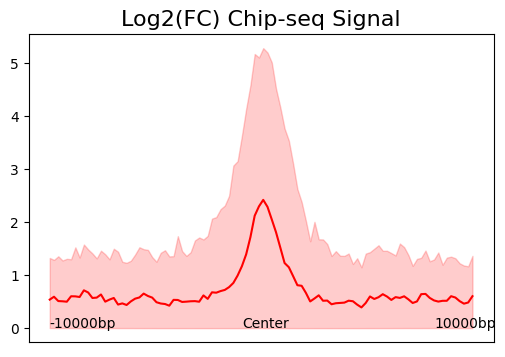

In [9]:
cc.pl.signal_plot(mtx_HCT116, alpha = 0.05, figsize=(6, 4))

Visualized by the plotting the signal heatmap plot.

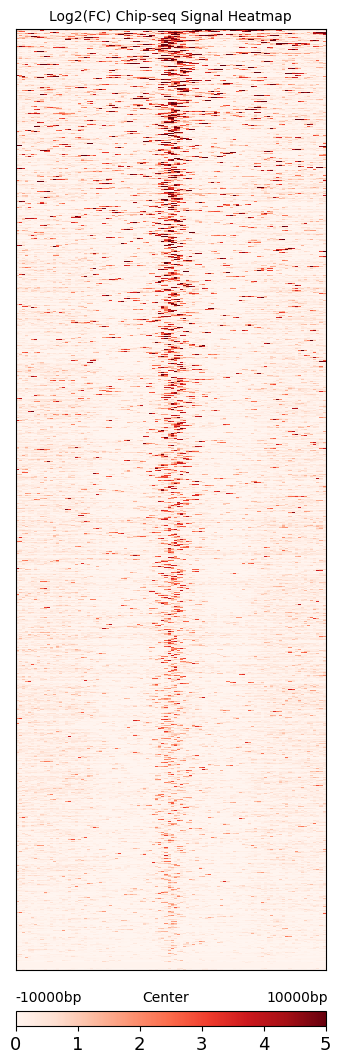

In [10]:
cc.pl.signal_heatmap(mtx_HCT116,pad = 0.035)

We can now use HOMER to call motifs.  We hope to find the canonical Sp1 motif enriched under the call peaks.

In [11]:
cc.tl.call_motif("peak_HCT116.bed",reference ="hg38",save_homer = "Homer/peak_HCT116", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

Peak data peak_HCT116.bed is used here.



	Position file = peak_HCT116.bed
	Genome = hg38
	Output Directory = Homer/peak_HCT116
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 3008
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 3008
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from file: /ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa)
	Extracting 334 sequences from chr1
	Extracting 147 sequences from chr10
	Extracting 132 sequences from chr11
	Extracting 179 sequences fr

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



In the motif analysis result, SP1 is the most significant motif.


<img src="peak_HCT116.png" alt="drawing" width="800"/>

Do the exact same thing for K562 SP1 data.

In [12]:
# read experiment data
K562_SP1 = cc.datasets.SP1_K562HCT116_data(data="K562_SP1_qbed")
K562_SP1

Chr     Start       End  Reads Direction            Barcodes
0       chr1     16529     16533    163         -  GCTCCTAAGTACGTTC-1
1       chr1     29884     29888     10         +  CTCACACCAGACGCTC-1
2       chr1     29884     29888    155         +  TGGCCAGCACCCATTC-1
3       chr1     29884     29888    285         +  GTGGGTCCACGGCCAT-1
4       chr1     29884     29888      7         +  CGTCTACTCAACACGT-1
...      ...       ...       ...    ...       ...                 ...
327460  chrY  57061562  57061566      6         +  CTCATTATCATCATTC-1
327461  chrY  57061562  57061566     67         +  TGCGTGGCATTAGGCT-1
327462  chrY  57145084  57145088      2         -  ACATACGTCGCGCCAA-1
327463  chrY  57148630  57148634      2         -  TATGCCCGTACAGTTC-1
327464  chrY  57183913  57183917    228         -  AAACCTGGTCCTGCTT-1

[327465 rows x 6 columns]

In [13]:
# read background data
K562_brd4 =cc.datasets.SP1_K562HCT116_data(data="K562_brd4_qbed")
K562_brd4 

Chr     Start       End  Reads Direction            Barcodes
0       chr1     30238     30242      3         +  TTTACTGCATAAAGGT-1
1       chr1     30355     30359      2         -  ATCACGAAGAGTAATC-1
2       chr1     30355     30359     70         +  TTGAACGCAAATCCGT-1
3       chr1     31101     31105      2         +  CCTCAGTCATCAGTAC-1
4       chr1     32116     32120      5         +  CTAGTGAAGACAAAGG-1
...      ...       ...       ...    ...       ...                 ...
107380  chrY  57080210  57080214      9         -  AAGGAGCCAGTATAAG-1
107381  chrY  57087785  57087789     24         -  CGAGCCAGTCTCTCTG-1
107382  chrY  57144853  57144857      5         +  GAAGCAGTCCCATTTA-1
107383  chrY  57183772  57183776      2         -  TCTTTCCTCTTGCCGT-1
107384  chrY  57204853  57204857    369         -  ATAACGCAGTTTGCGT-1

[107385 rows x 6 columns]

In [14]:
peak_data_K562 = cc.pp.call_peaks(K562_SP1, K562_brd4, method = "MACCS", reference = "hg38", window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.0001,  pvalue_cutoffbg = 0.1, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak_k562.bed")
peak_data_K562

For the MACCS method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 24/24 [02:12<00:00,  5.53s/it]


Chr     Start       End      Center  Experiment Insertions  \
0     chr1     29684     30087     29884.0                      6   
1     chr1     36239     38107     37578.0                     24   
2     chr1    198893    201208    200869.0                     28   
3     chr1    203351    207161    205004.0                     92   
4     chr1    265549    266336    265749.0                      5   
...    ...       ...       ...         ...                    ...   
9404  chrY  15158250  15158653  15158450.0                     11   
9405  chrY  16985442  16985845  16985642.0                      5   
9406  chrY  19753311  19753714  19753511.0                     33   
9407  chrY  21011133  21011828  21011333.0                      5   
9408  chrY  56952574  56957328  56953707.0                     40   

      Background insertions  Reference Insertions  pvalue Reference  \
0                         0                     1      8.878753e-11   
1                         2                    15      0.000000e+00   
2                         2                    11      0.000000e+00   
3                        13                    22      0.000000e+00   
4                         0                     3      3.731359e-08   
...                     ...                   ...               ...   
9404                      0                     1      0.000000e+00   
9405                      0                     2      1.806731e-09   
9406                      0                     1      0.000000e+00   
9407                      0                     4      2.510448e-09   
9408                      1                    37      0.000000e+00   

      pvalue Background  Fraction Experiment  TPH Experiment  \
0          1.546531e-04             0.000018     1832.256882   
1          1.486029e-03             0.000073     7329.027530   
2          6.927041e-05             0.000086     8550.532118   
3          4.337485e-05             0.000281    28094.605530   
4          4.678840e-03             0.000015     1526.880735   
...                 ...                  ...             ...   
9404       1.546531e-04             0.000034     3359.137618   
9405       4.678840e-03             0.000015     1526.880735   
9406       2.269296e-13             0.000101    10077.412853   
9407       4.678840e-03             0.000015     1526.880735   
9408       2.427052e-06             0.000122    12215.045883   

      Fraction background  TPH background  TPH background subtracted  \
0                0.000000        0.000000                1832.256882   
1                0.000019     1862.457513                5466.570017   
2                0.000019     1862.457513                6688.074605   
3                0.000121    12105.973832               15988.631698   
4                0.000000        0.000000                1526.880735   
...                   ...             ...                        ...   
9404             0.000000        0.000000                3359.137618   
9405             0.000000        0.000000                1526.880735   
9406             0.000000        0.000000               10077.412853   
9407             0.000000        0.000000                1526.880735   
9408             0.000009      931.228756               11283.817126   

      pvalue_adj Reference  
0             3.323285e-08  
1             0.000000e+00  
2             0.000000e+00  
3             0.000000e+00  
4             1.056034e-05  
...                    ...  
9404          0.000000e+00  
9405          6.060202e-07  
9406          0.000000e+00  
9407          8.296735e-07  
9408          0.000000e+00  

[9409 rows x 15 columns]

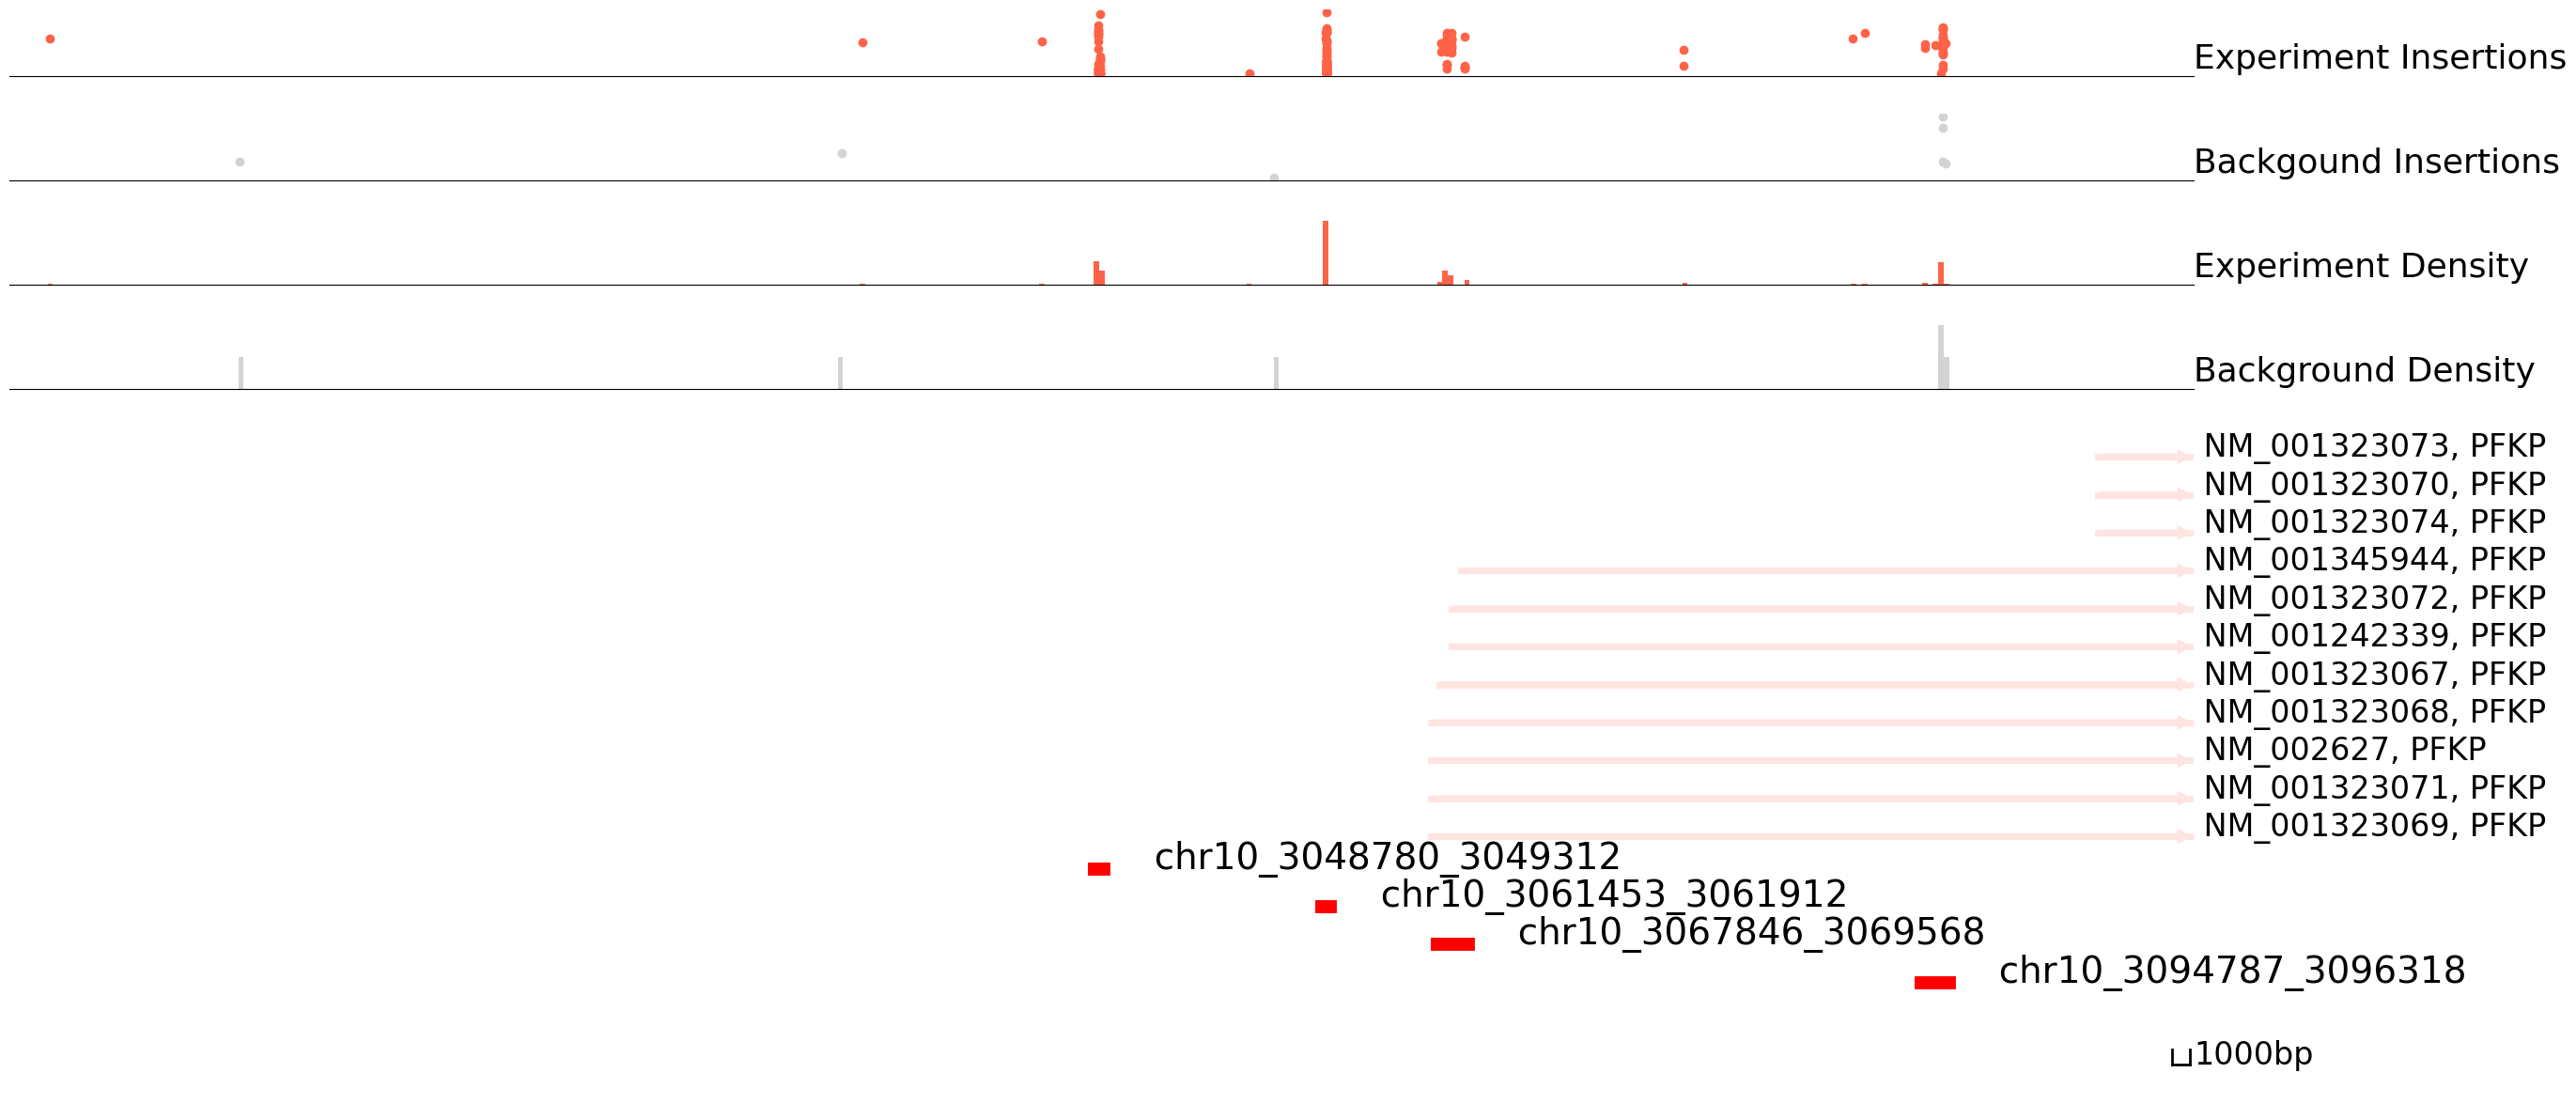

In [15]:
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data_K562,K562_SP1, "hg38", K562_brd4 , font_size=2, 
                figsize = (30,15),peak_line = 4,save = False,bins =400, plotsize = [1,1,5], example_length = 1000)

In [16]:
qbed = {"SP1":K562_SP1, "Brd4": K562_brd4}
bed = {"peak":peak_data_K562}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'hg38')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=hg38&hub=https://companion.epigenomegateway.org//task/0cdc08dcda18476bede79a0eefcb72ec/output//datahub.json


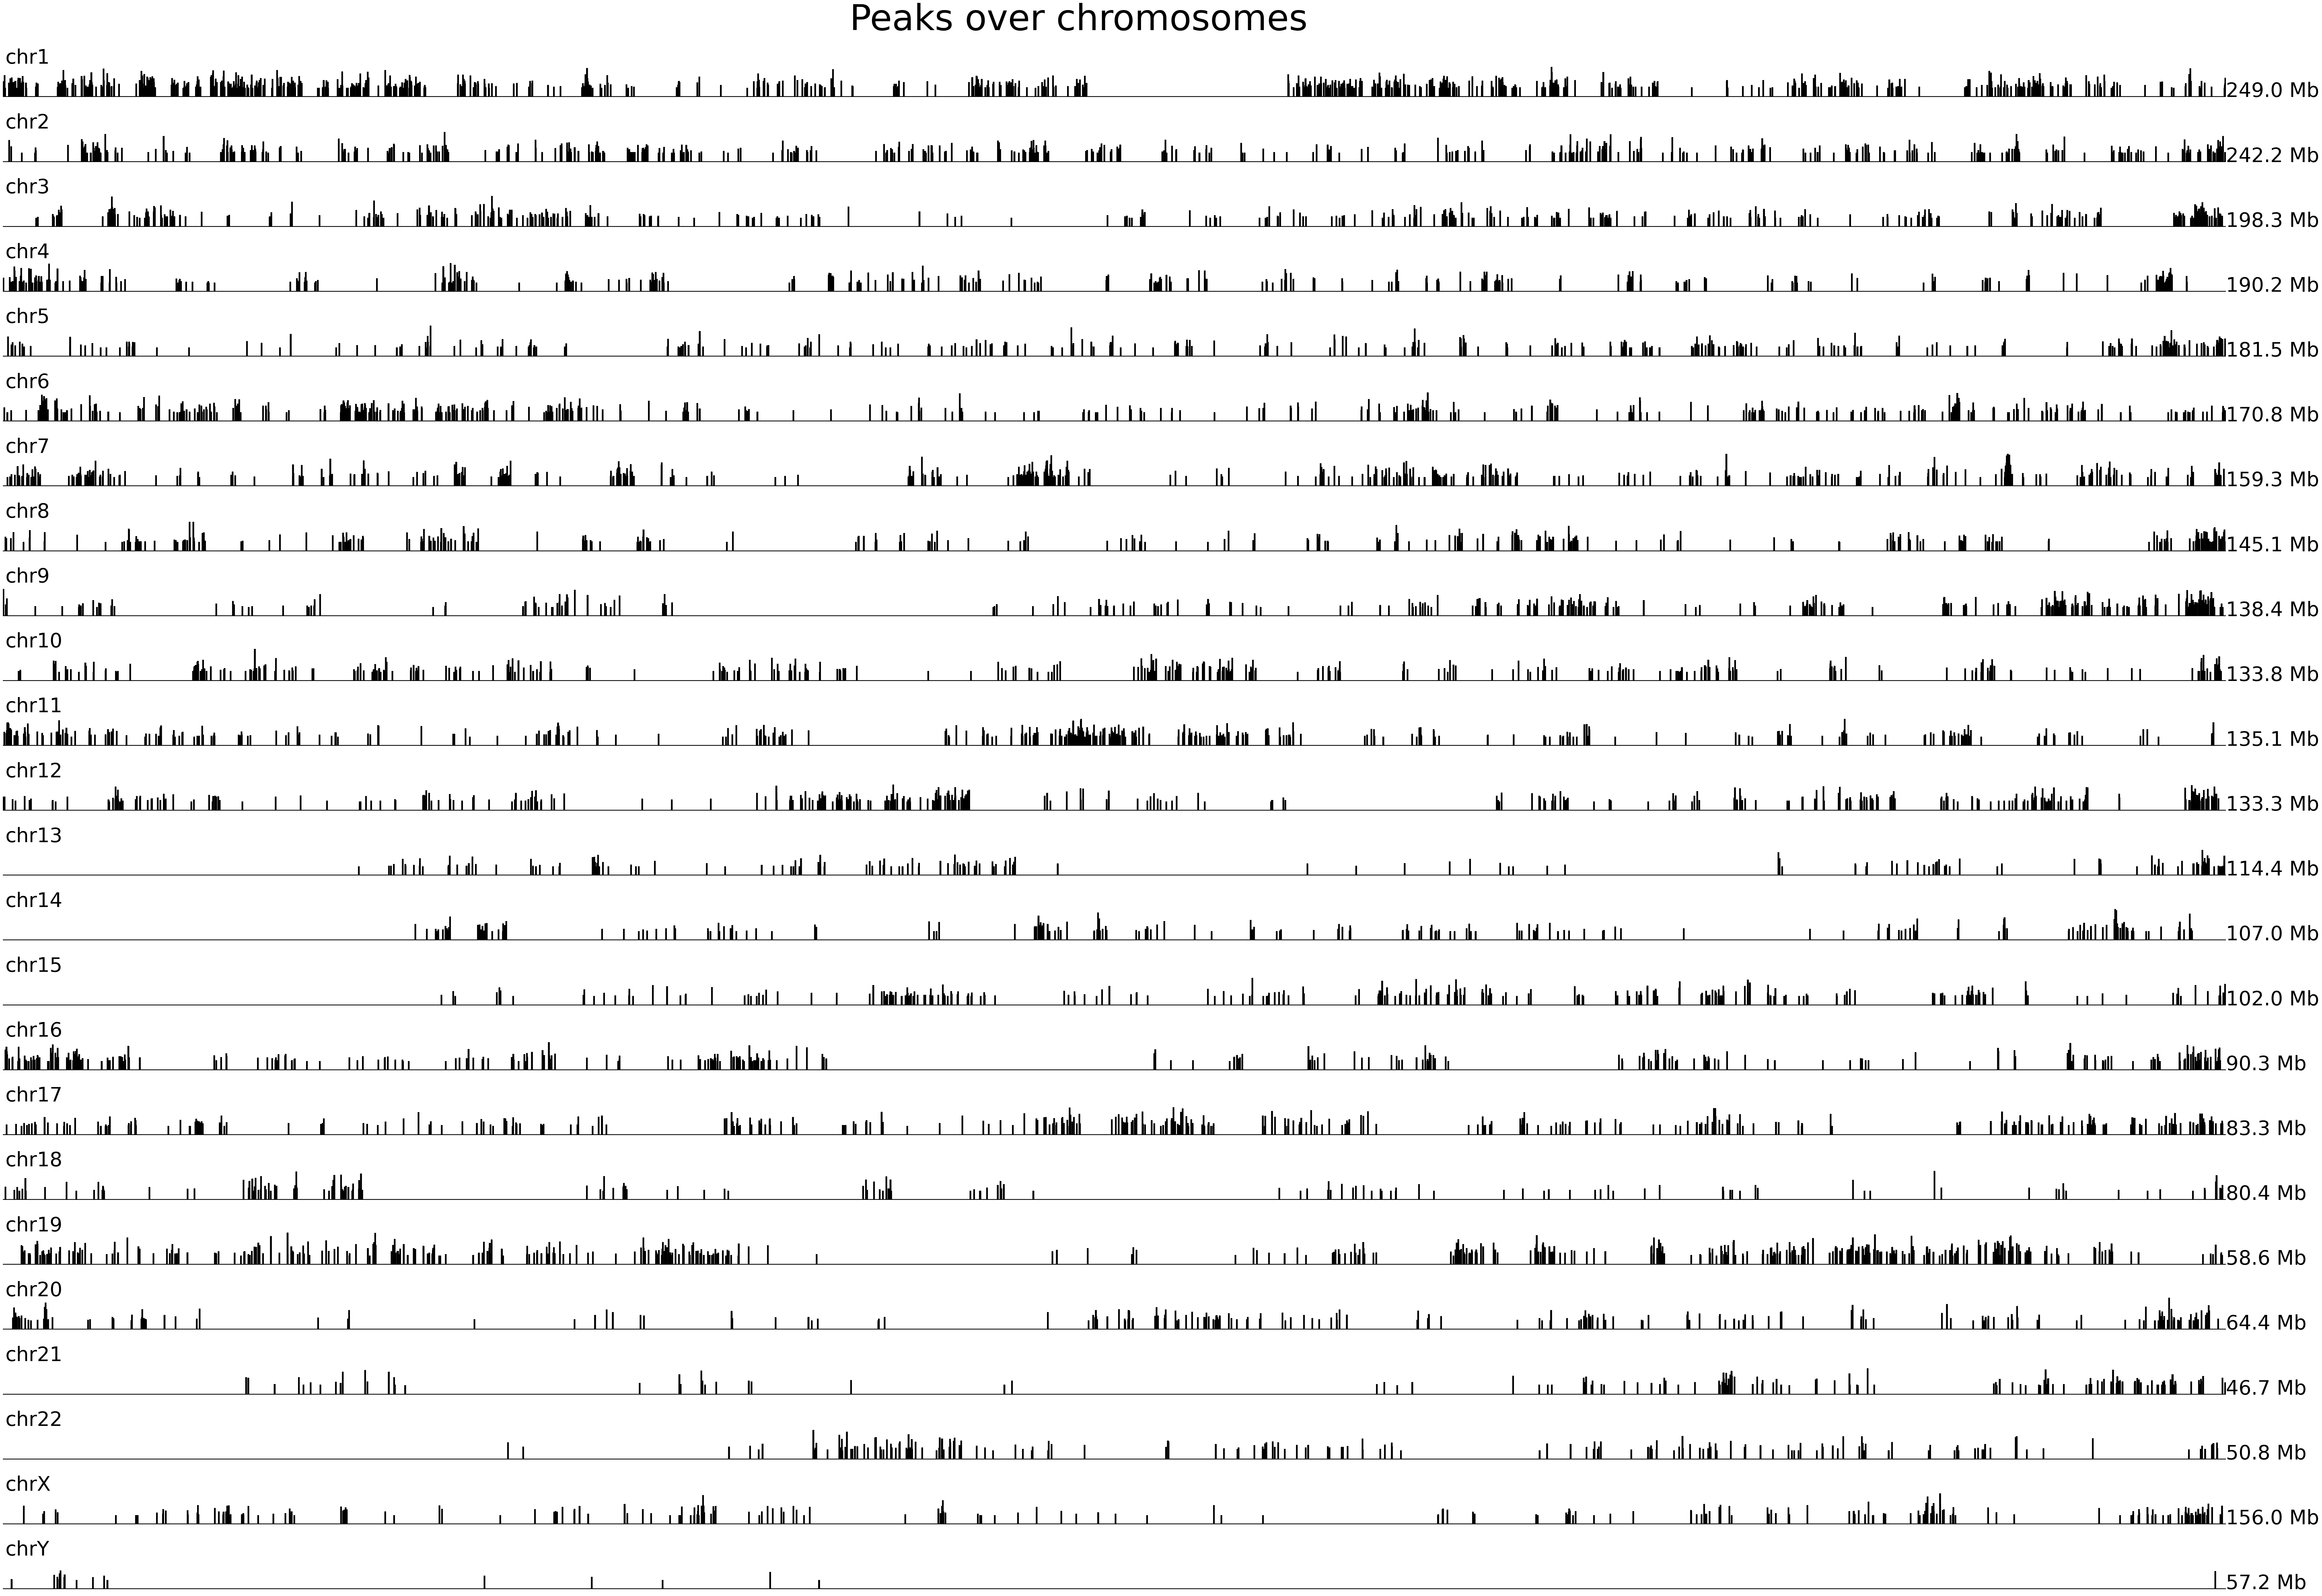

In [17]:
cc.pl.whole_peaks(peak_data_K562, reference = "hg38",figsize=(100, 70),height_scale = 1.7)

We can see that SP1 binds much more frequently in K562 than HCT116.

We can then check with reference Chip-seq data of SP1 in K562 from [ENCSR372IML](https://www.encodeproject.org/experiments/ENCSR372IML/) (and use the bigWig file [ENCFF588UII](https://www.encodeproject.org/files/ENCFF588UII/) generated by it）.

Download the data if needed:

``` Python
    !wget https://www.encodeproject.org/files/ENCFF588UII/@@download/ENCFF588UII.bigWig
```

In [18]:
mtx_K562 = cc.pl.calculate_signal(peak_data_K562, chipseq_signal = "ENCFF588UII.bigWig")

100%|██████████| 9409/9409 [01:03<00:00, 147.07it/s]


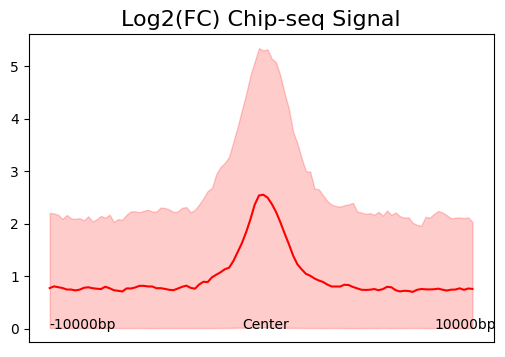

In [19]:
cc.pl.signal_plot(mtx_K562, alpha = 0.05, figsize=(6, 4))

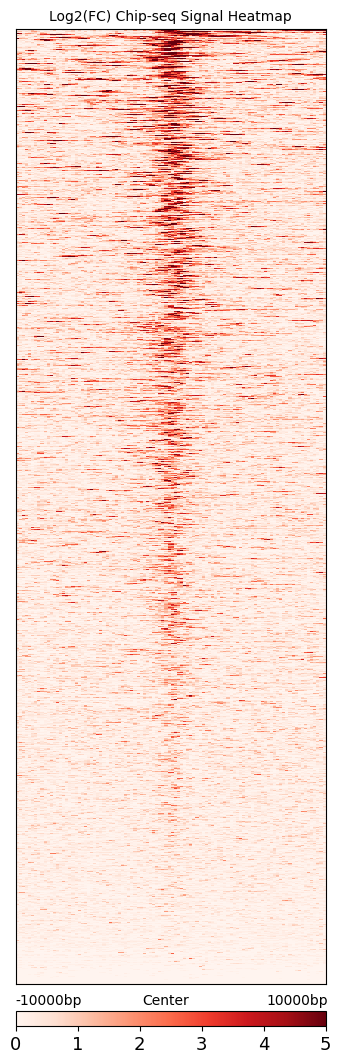

In [20]:
cc.pl.signal_heatmap(mtx_K562,pad =  0.023, belowlength = 100)

We can see that calling cards peaks are consistent with Chip-seq data. Peak centers tend to have a higher signal and the signal goes lower as the distance increases.

Call motif to check the peak results.

In [21]:
cc.tl.call_motif("peak_k562.bed",reference ="hg38",save_homer = "Homer/peak_k562", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

Peak data peak_k562.bed is used here.



	Position file = peak_k562.bed
	Genome = hg38
	Output Directory = Homer/peak_k562
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 9409
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 9409
		Redundant Peak IDs: 2
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	2 duplicate peak IDs out of 9409 total peaks
	Background files for 1000 bp fragments found.

	Extracting sequences from file: /ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/ref/rmlab/software/homer/.//data/genomes/hg38///genome.fa)
	Extracting 1062 sequences from chr1

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



In the motif analysis result, SP1 is the most significant motif.


<img src="peak_k562.png" alt="drawing" width="800"/>

Next we want to identify binding sites that are differentially bound in K562 and Hct-116 cells. This can be challenging as the two samples may have slightly shifted peaks centers at a given genomic region, leading to false positive differential peak calls. To handle this, Pycallingcards first combines the insertions from the two samples and calls peaks on the joint dataset. We do this using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).

In [22]:
import pybedtools
peak = cc.rd.combine_qbed([peak_data_HCT116, peak_data_K562])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
peak_data 

Chr     Start       End
0      chr1     29684     30087
1      chr1     36239     38107
2      chr1    198893    201208
3      chr1    203351    207161
4      chr1    265549    266336
...     ...       ...       ...
10445  chrY  15158250  15158653
10446  chrY  16985442  16985845
10447  chrY  19753311  19753714
10448  chrY  21011133  21011828
10449  chrY  56952574  56957328

[10450 rows x 3 columns]

We can now visualize the peaks called on the joint dataset.

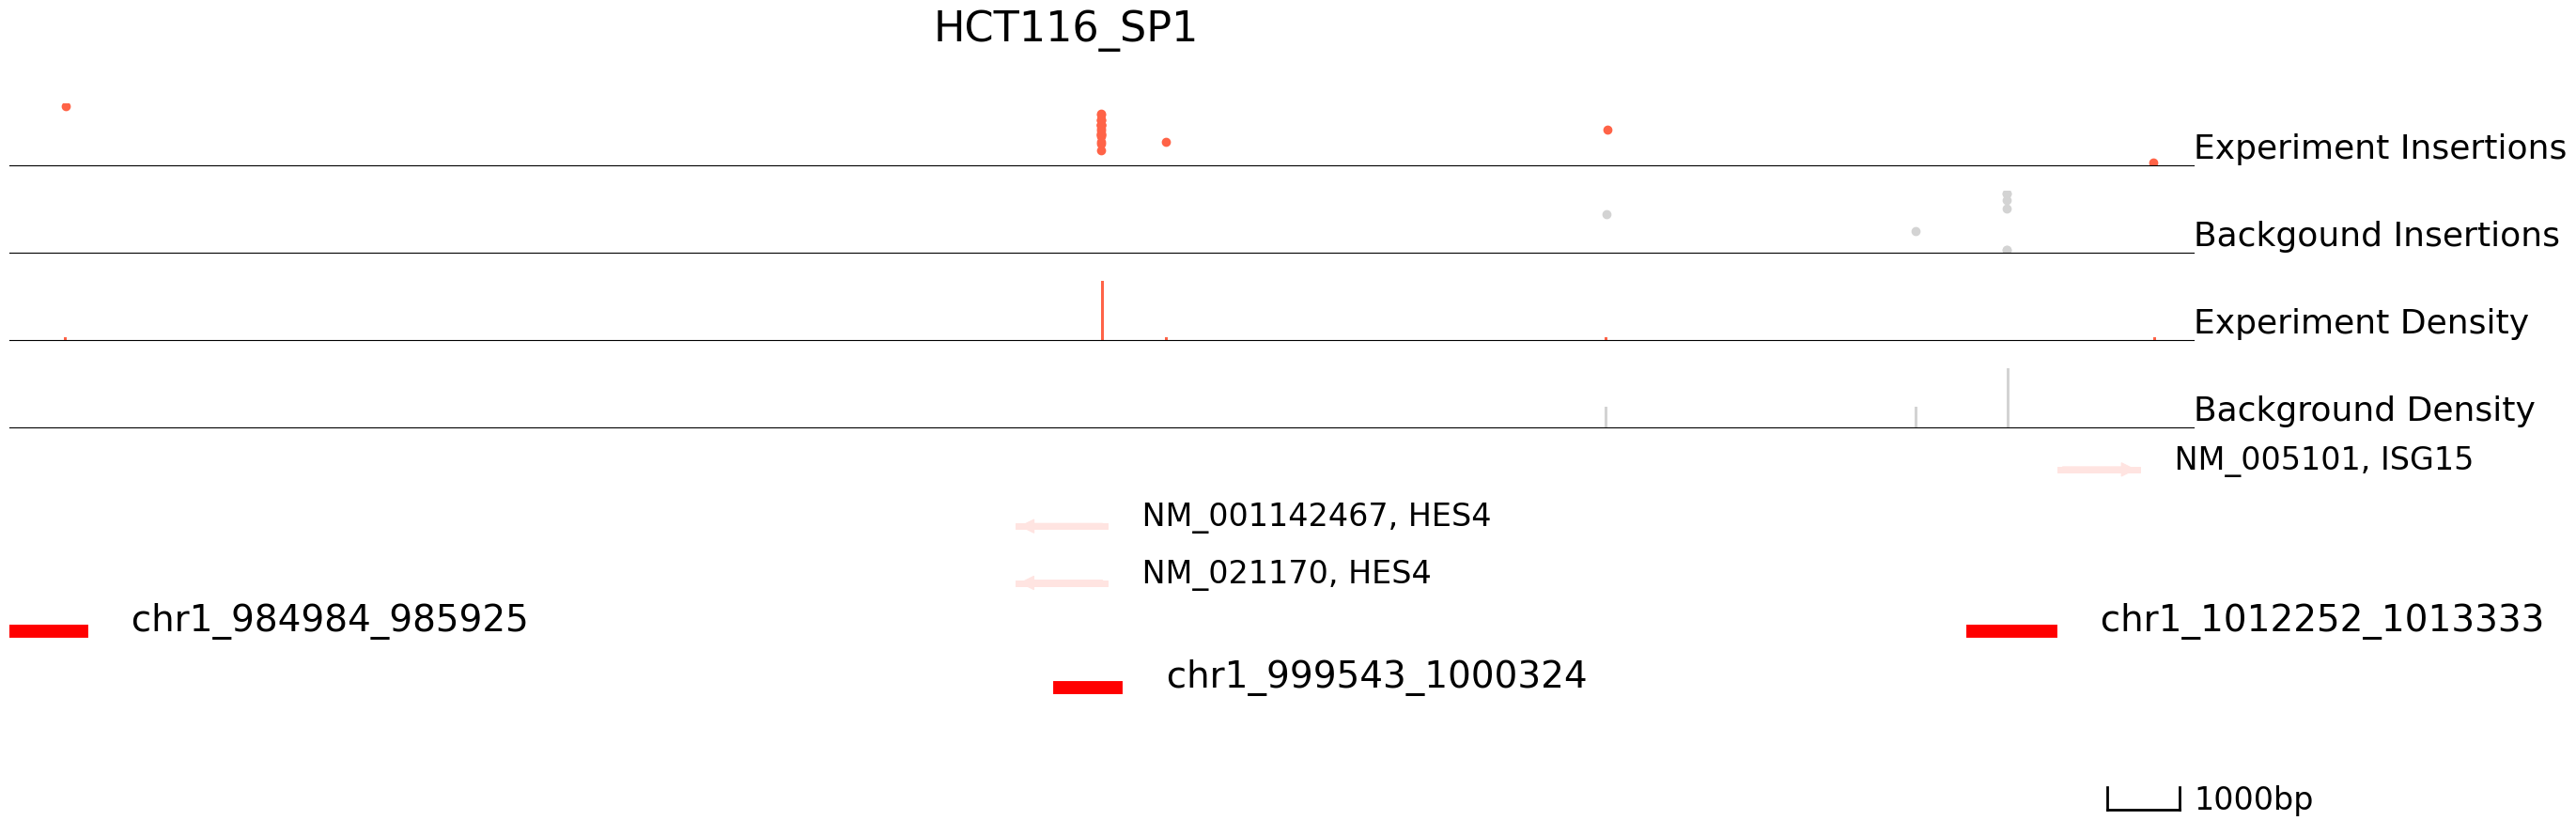

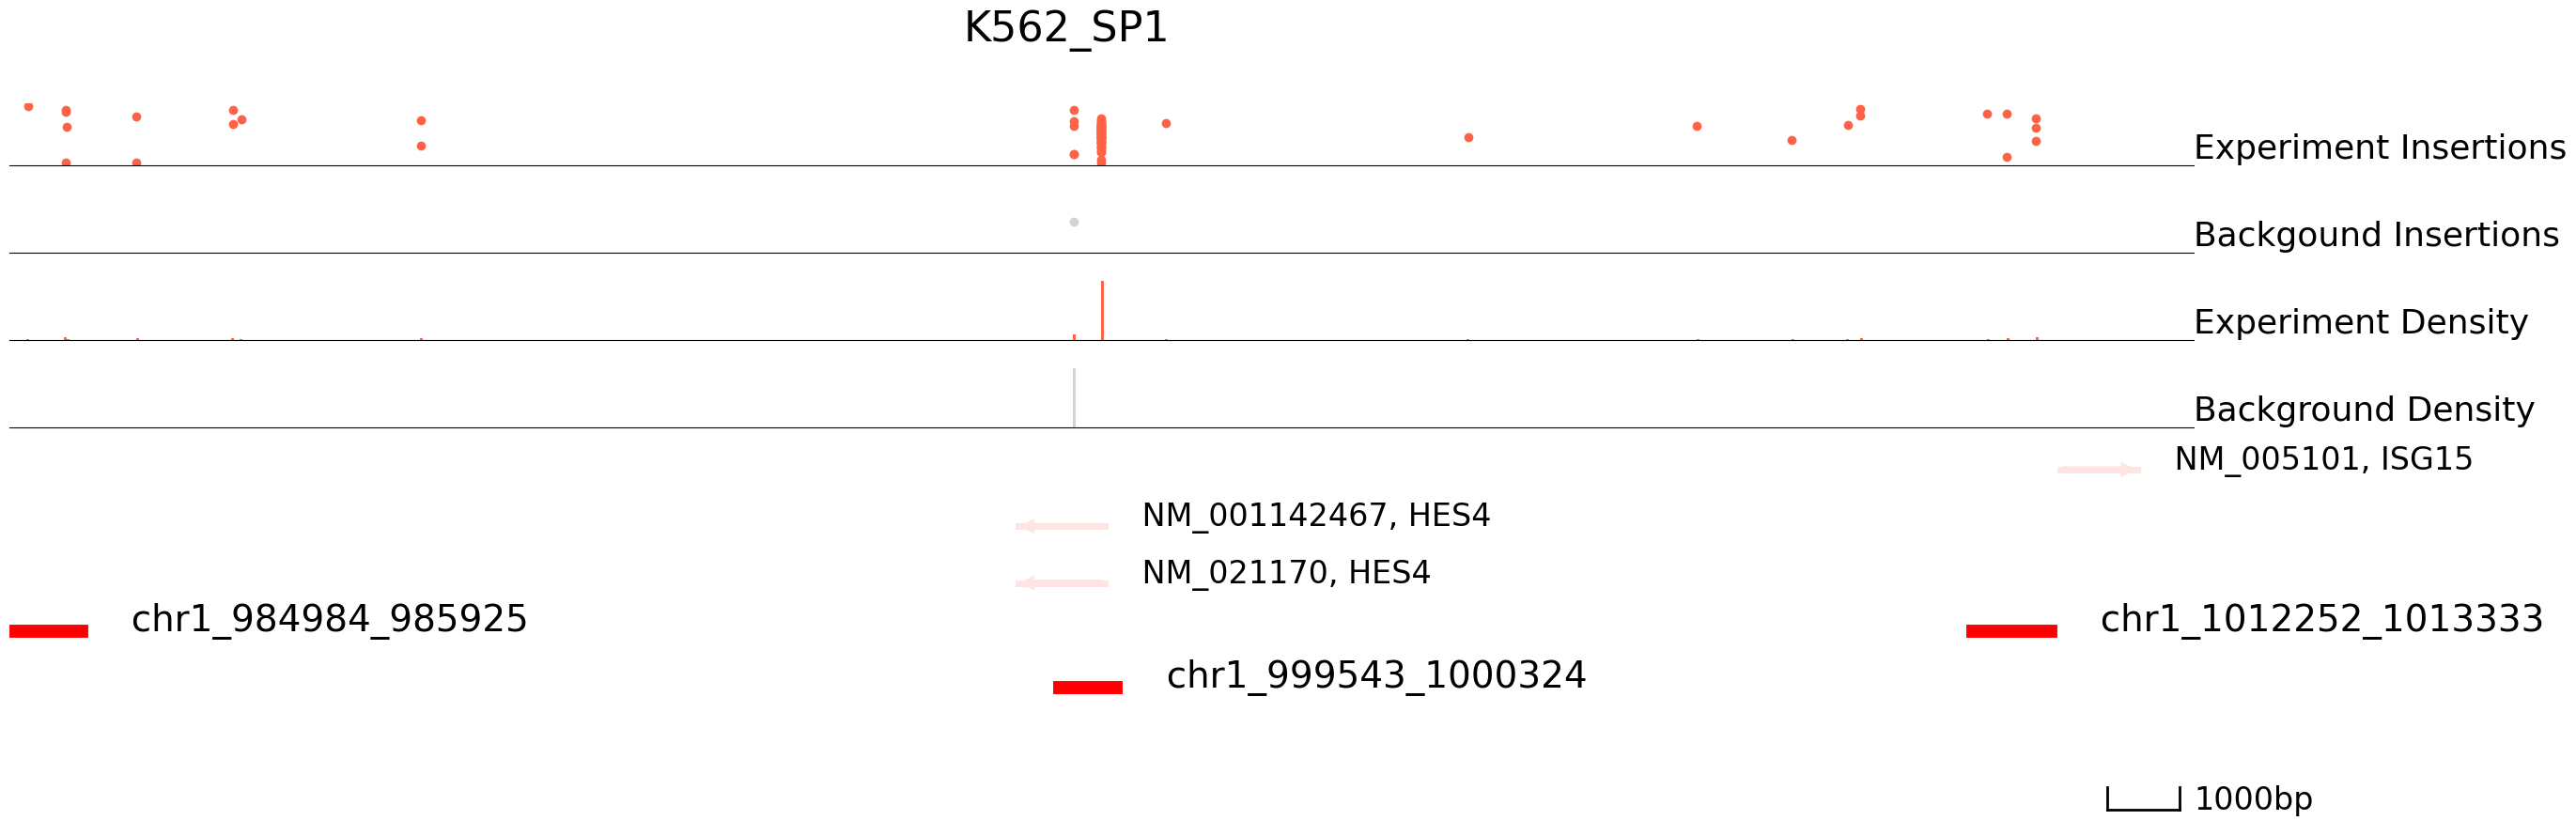

In [23]:
cc.pl.draw_area("chr1",999921,1000324,15000,peak_data, HCT116_SP1, "hg38", HCT116_brd4, font_size=2,
                figsize = (30,10),peak_line = 2,save = False,plotsize = [1,1,3], example_length = 1000,
                title = "HCT116_SP1")
cc.pl.draw_area("chr1",999921,1000324,15000,peak_data, K562_SP1, "hg38", K562_brd4, font_size=2,
                figsize = (30,10),peak_line = 2,save = False,plotsize = [1,1,3], example_length = 1000,
                title = "K562_SP1")

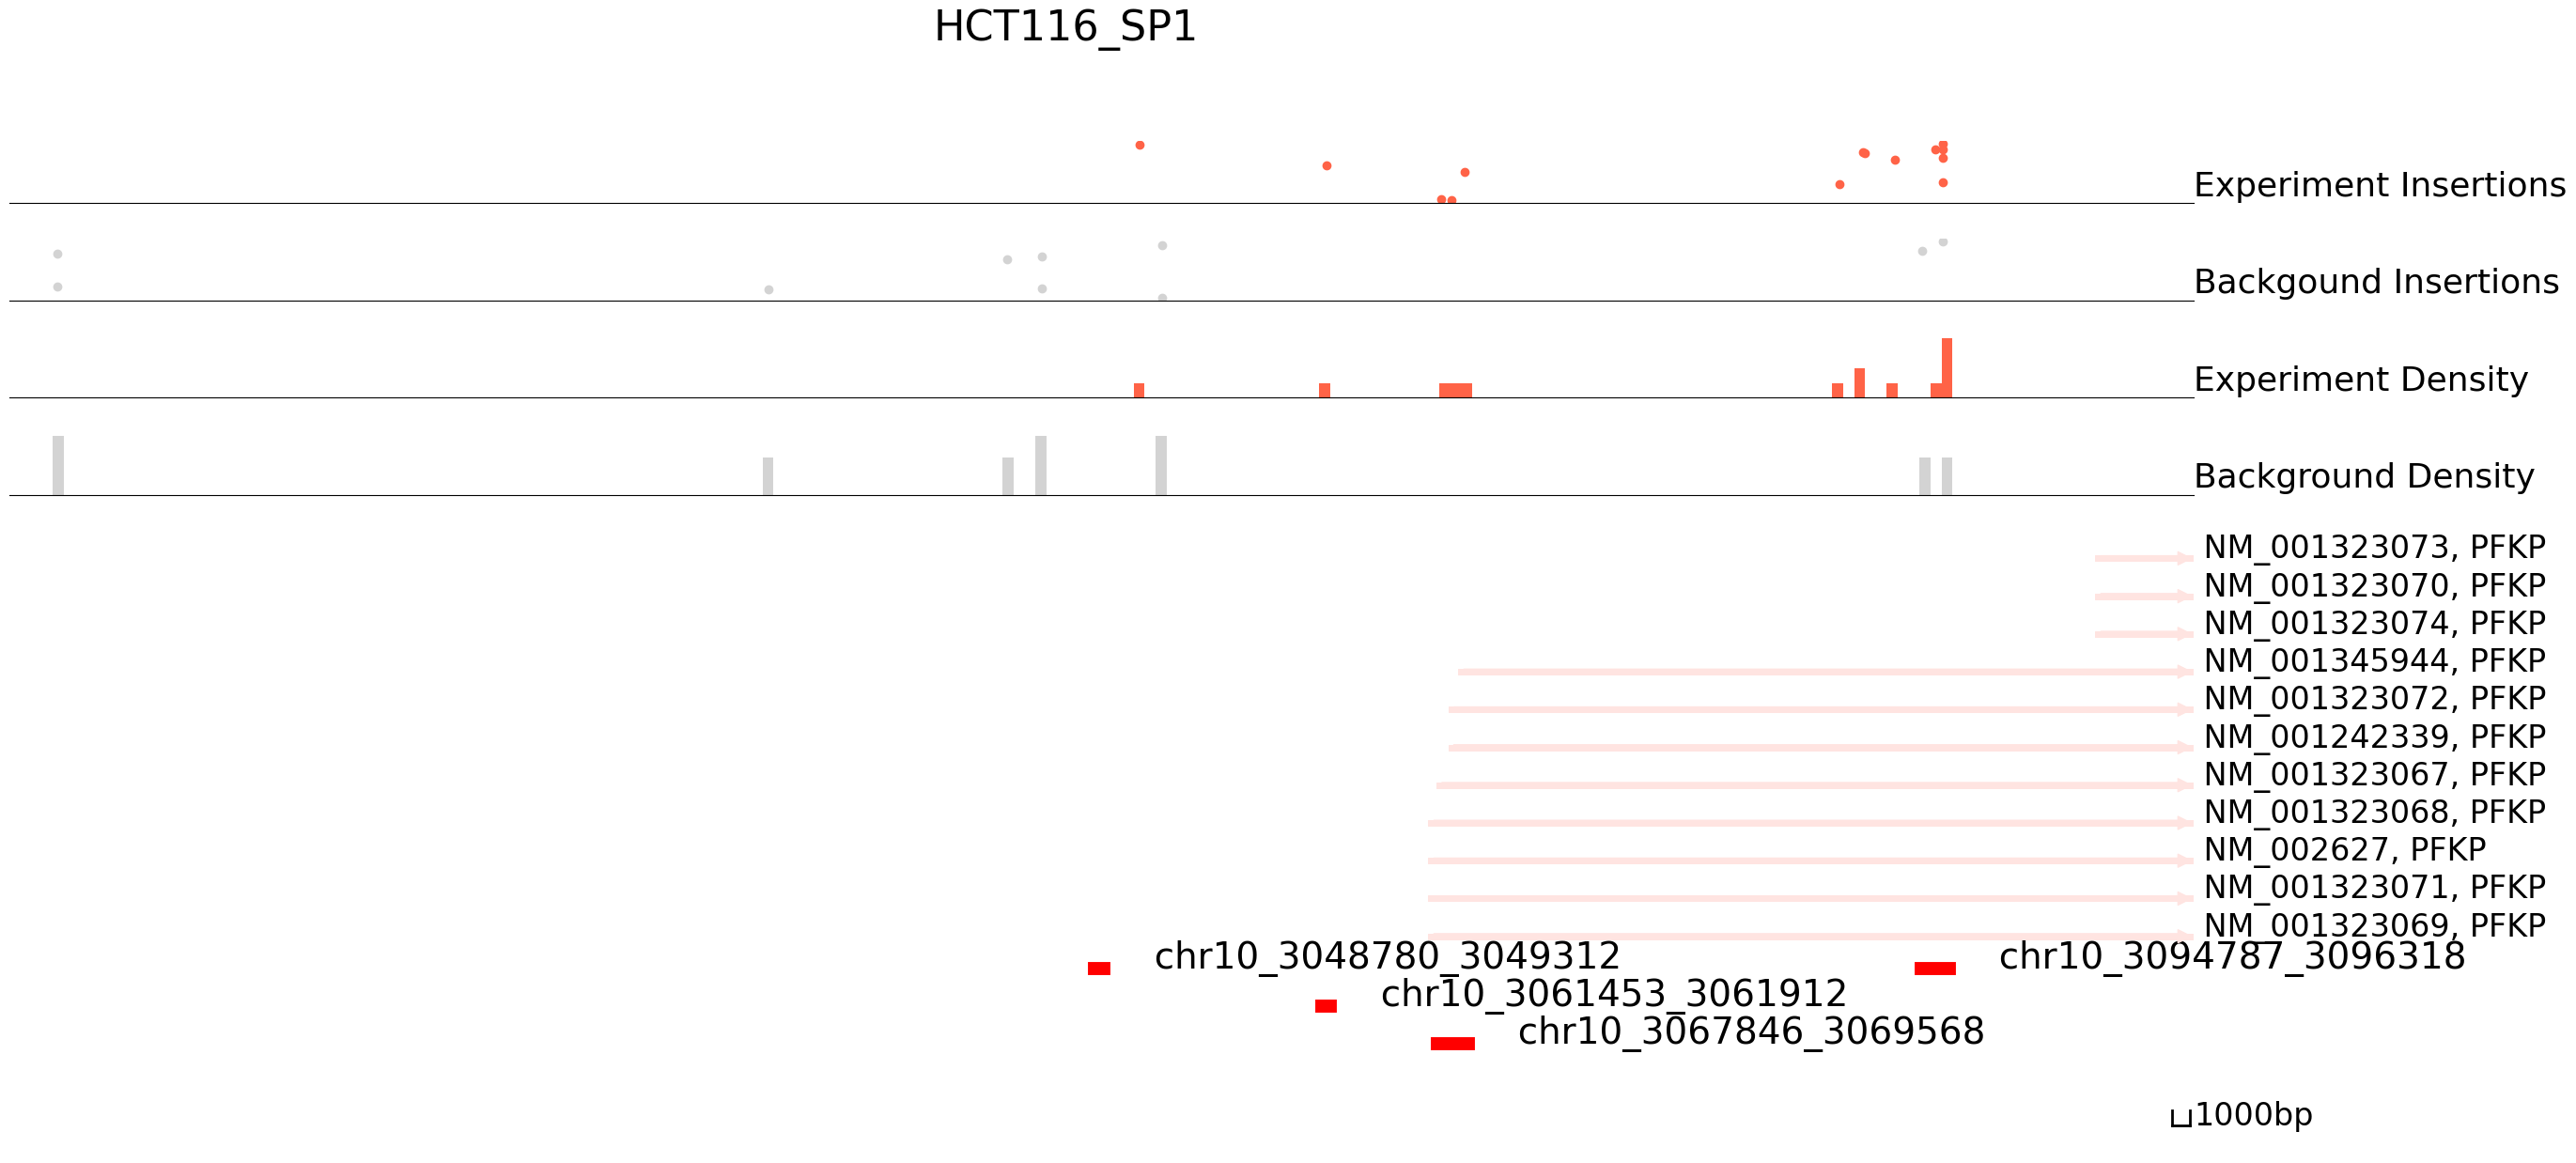

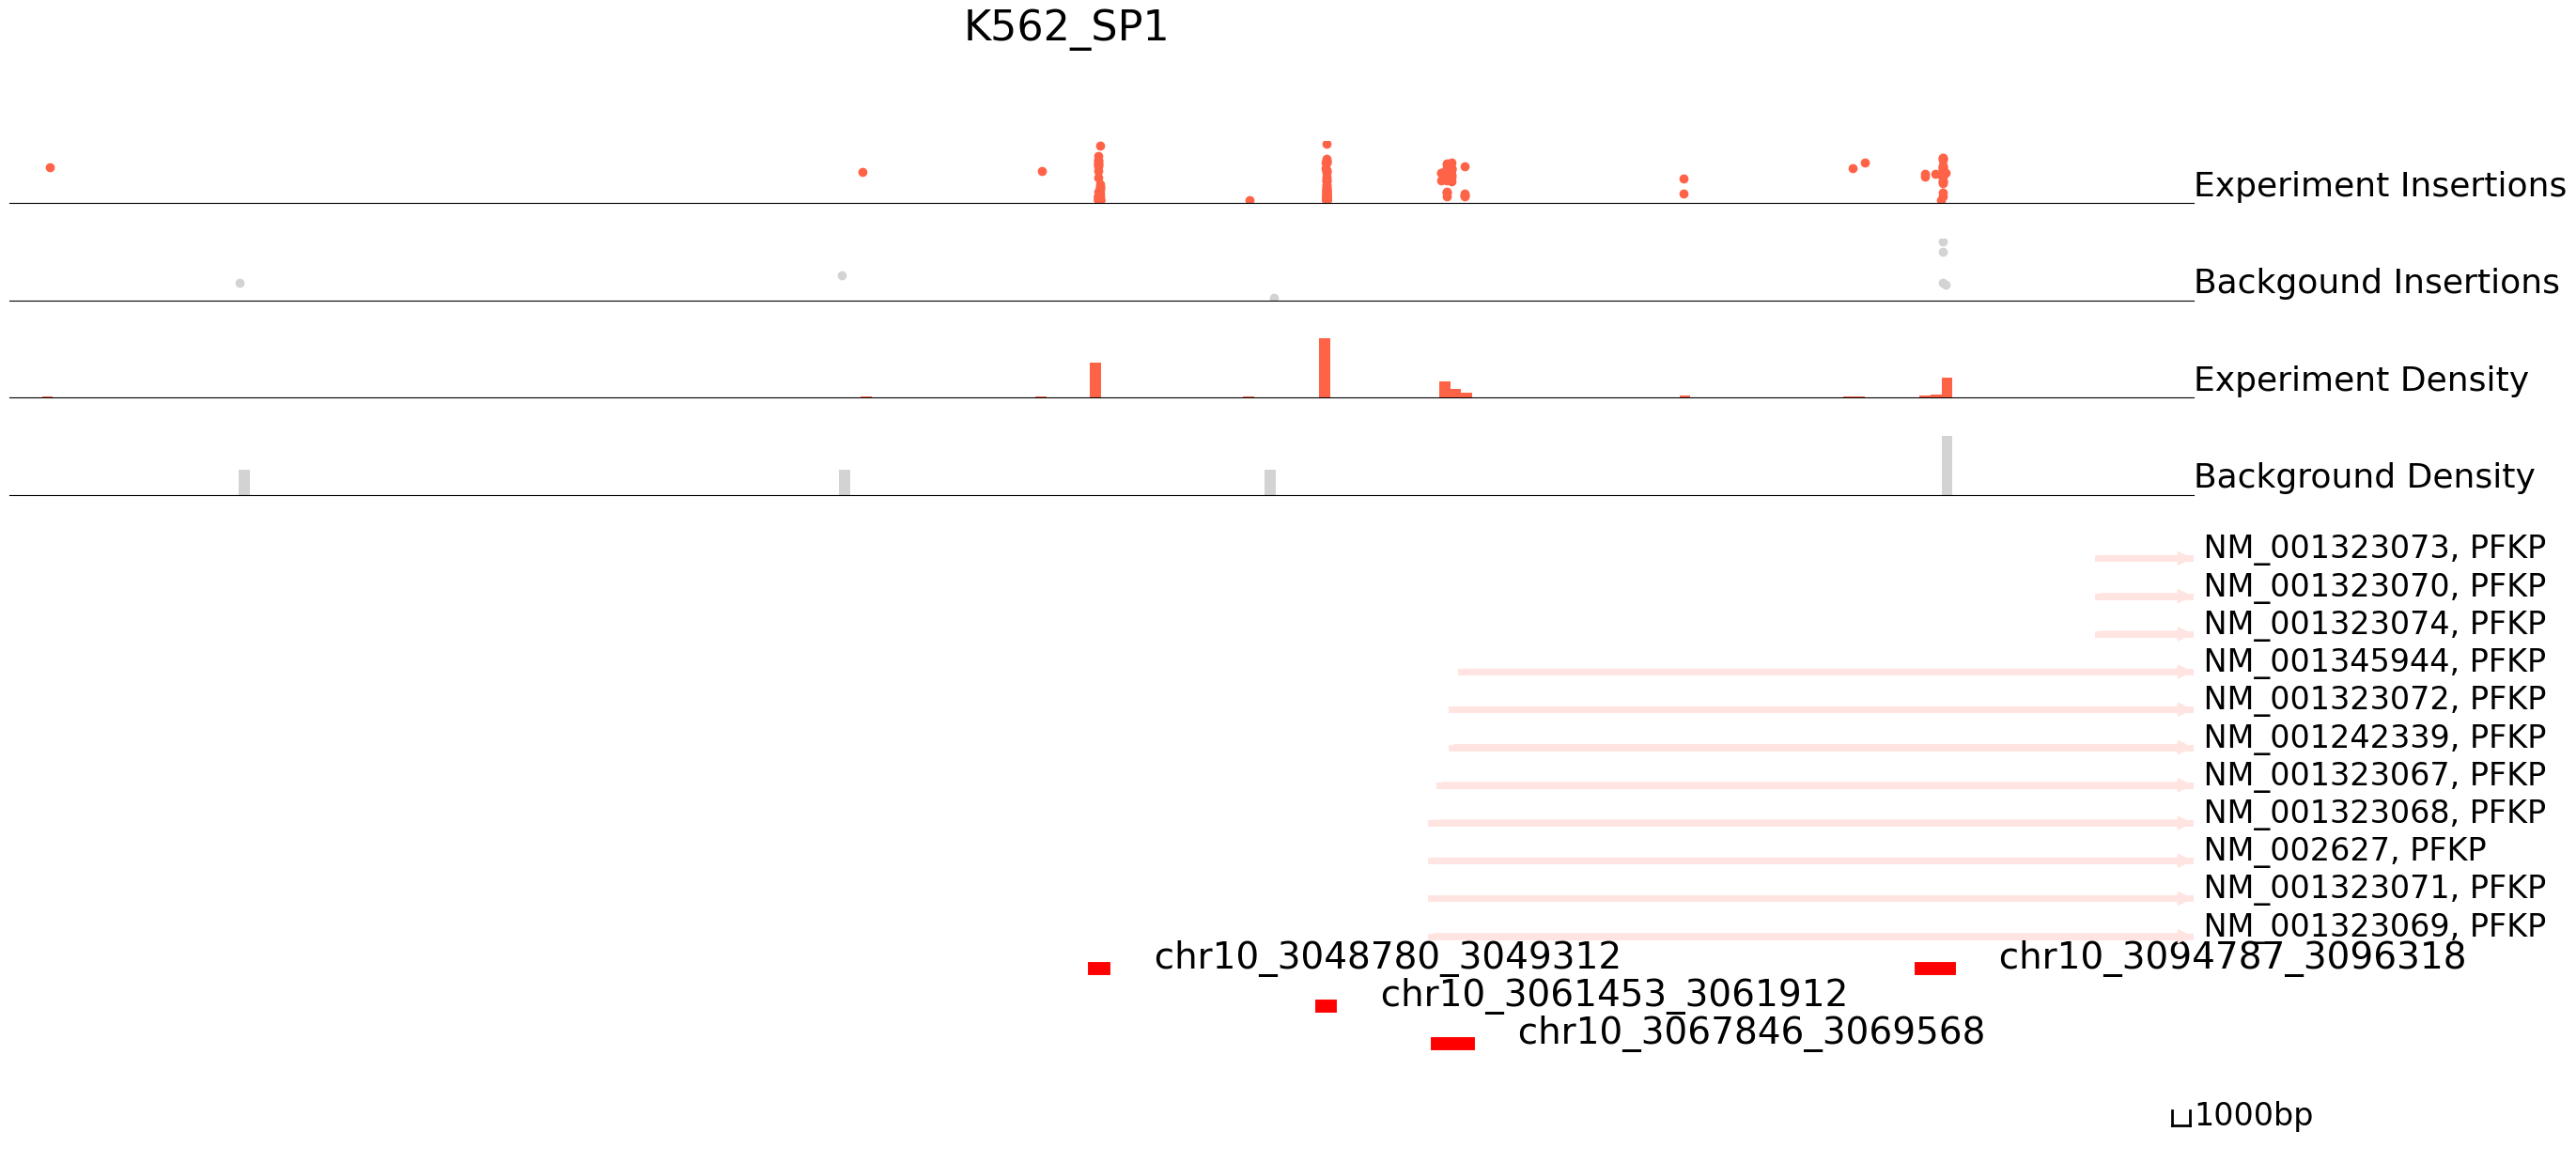

In [24]:
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data, HCT116_SP1, "hg38", HCT116_brd4, font_size=2,
                figsize = (30,14), peak_line = 3,save = False, bins = 200, plotsize = [1,1,5], 
                example_length = 1000, title = "HCT116_SP1")
cc.pl.draw_area("chr10",3048452,3049913,60000,peak_data, K562_SP1, "hg38", K562_brd4, font_size=2,
                figsize = (30,14), peak_line = 3,save = False, bins = 200, plotsize = [1,1,5], 
                example_length = 1000, title = "K562_SP1")

The results seem to be good! Congratulations! Now we can annotate the peaks using bedtools.

In [25]:
peak_annotation = cc.pp.annotation(peak_data, reference = "hg38")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


Chr     Start       End Nearest Refseq1 Gene Name1 Nearest Refseq2  \
0      chr1     29684     30087       NR_036051  MIR1302-2       NR_024540   
1      chr1     36239     38107       NR_026818    FAM138A       NR_036051   
2      chr1    198893    201208       NR_026823    FAM138D       NR_107063   
3      chr1    203351    207161       NR_026823    FAM138D       NR_107063   
4      chr1    265549    266336       NR_026823    FAM138D       NR_107063   
...     ...       ...       ...             ...        ...             ...   
10445  chrY  15158250  15158653    NM_001206850     NLGN4Y       NR_046504   
10446  chrY  16985442  16985845       NR_028083   FAM41AY1       NR_002160   
10447  chrY  19753311  19753714    NM_001146706      KDM5D       NR_045128   
10448  chrY  21011133  21011828    NM_001039567     RPS4Y2    NM_001282471   
10449  chrY  56952574  56957328       NM_005840      SPRY3    NM_001145149   

       Gene Name2  
0          WASH7P  
1       MIR1302-2  
2       MIR6859-3  
3       MIR6859-3  
4       MIR6859-3  
...           ...  
10445  NLGN4Y-AS1  
10446     FAM224B  
10447      TXLNGY  
10448       PRORY  
10449       VAMP7  

[10450 rows x 7 columns]

Combine the two experiment qbed files to make anndata object.

In [26]:
exp_qbed = pd.concat([K562_SP1,HCT116_SP1])
exp_qbed

Chr     Start       End  Reads Direction            Barcodes
0      chr1     16529     16533    163         -  GCTCCTAAGTACGTTC-1
1      chr1     29884     29888     10         +  CTCACACCAGACGCTC-1
2      chr1     29884     29888    155         +  TGGCCAGCACCCATTC-1
3      chr1     29884     29888    285         +  GTGGGTCCACGGCCAT-1
4      chr1     29884     29888      7         +  CGTCTACTCAACACGT-1
...     ...       ...       ...    ...       ...                 ...
77205  chrY  25518788  25518792      2         +  TGGGCGTTCGAACGGA-1
77206  chrY  56987633  56987637     13         +  CAGTCCTAGGCACATG-1
77207  chrY  57080855  57080859     17         +  CGGAGCTCATCGACGC-1
77208  chrY  57080855  57080859      7         +  GTAACGTAGTTACGGG-1
77209  chrY  57080855  57080859      9         +  TCAGCAAGTTGAACTC-1

[404675 rows x 6 columns]

Read the barcode file.

In [27]:
barcodes = cc.datasets.SP1_K562HCT116_data(data = "barcodes")
barcodes = barcodes.drop_duplicates(subset=['Index'])
barcodes

Index cluster
0      AAACCTGAGAAAGTGG-1  HCT116
1      AAACCTGAGACCGGAT-1    K562
2      AAACCTGAGACTAGAT-1  HCT116
3      AAACCTGAGAGCTTCT-1  HCT116
4      AAACCTGAGAGTACCG-1  HCT116
...                   ...     ...
52206  TTTGTCATCTCCGGTT-1    K562
52207  TTTGTCATCTCGATGA-1    K562
52208  TTTGTCATCTCTAAGG-1    K562
52209  TTTGTCATCTGGAGCC-1  HCT116
52210  TTTGTCATCTTGGGTA-1  HCT116

[51079 rows x 2 columns]

Now we will connect the peaks (and insertions under the peaks) to the cell barcode data.  To do so, we will use the qbed data, peak data and barcodes data to make a cell by peak anndata object.

In [28]:
adata_cc = cc.pp.make_Anndata(exp_qbed, peak_annotation, barcodes)
adata_cc

100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


AnnData object with n_obs × n_vars = 51079 × 10450
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Although one peak should have many insertions, there is a chance that all the cells from the peak were filtered by the RNA preprocesssing. In this case, we advise to filter the peaks. Additionally, we also recommend to filter cells that have very few insertions.

In [29]:
cc.pp.filter_peaks(adata_cc, min_counts = 5)
cc.pp.filter_peaks(adata_cc, min_cells = 5)
adata_cc

AnnData object with n_obs × n_vars = 51079 × 10448
    obs: 'cluster'
    var: 'Chr', 'Start', 'End', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts', 'n_cells'

Next we can perform differential peak analysis to determine which peaks are cell type specific. In this example, we use the *fisher exact test* to find peaks enriched in K562 versus Hct116 cells.

In [30]:
cc.tl.rank_peak_groups(adata_cc, "cluster", method = 'fisher_exact', key_added = 'fisher_exact')

100%|██████████| 2/2 [02:14<00:00, 67.19s/it]


We can plot the results for differential peak analysis.

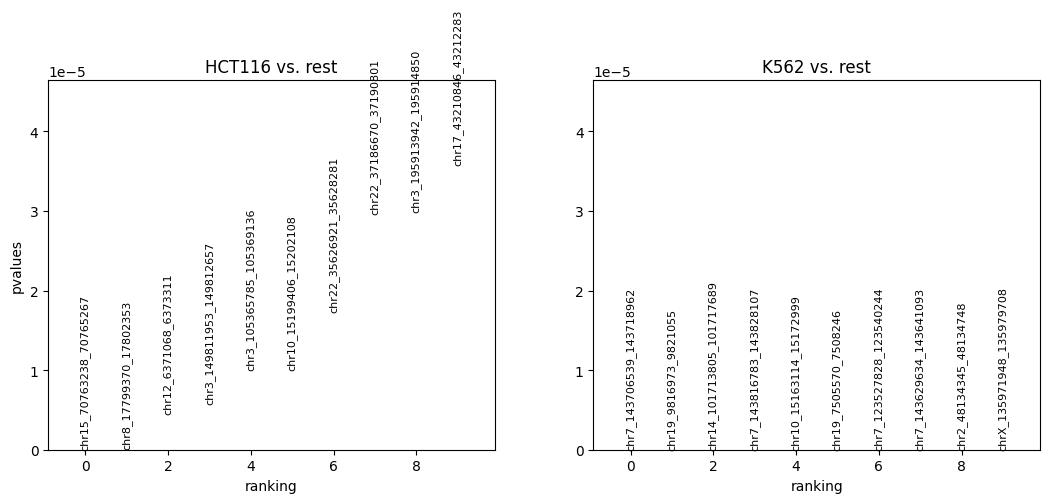

In [31]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact')

Now let's visualize some peaks that are differentially bound. The colored ones are the insertions for the cluster of interest (i.e. cell type) and the grey ones are insertions in the rest of the clusters. In this case there are only two clusters, HCT116 and K562. We observe large differences in Sp1 binding in HCT116 and K562 cells.

In [32]:
bg_qbed = pd.concat([K562_brd4, HCT116_brd4])
bg_qbed

Chr     Start       End  Reads Direction            Barcodes
0      chr1     30238     30242      3         +  TTTACTGCATAAAGGT-1
1      chr1     30355     30359      2         -  ATCACGAAGAGTAATC-1
2      chr1     30355     30359     70         +  TTGAACGCAAATCCGT-1
3      chr1     31101     31105      2         +  CCTCAGTCATCAGTAC-1
4      chr1     32116     32120      5         +  CTAGTGAAGACAAAGG-1
...     ...       ...       ...    ...       ...                 ...
37769  chrY  18037315  18037319      9         -  GCAGTTAAGATCTGAA-1
37770  chrY  24036504  24036508    168         +  GCAGTTAAGATCTGAA-1
37771  chrY  24036504  24036508    508         +  CATATGGCAGCCAGAA-1
37772  chrY  25633622  25633626     13         -  GCAGTTAAGATCTGAA-1
37773  chrY  25633622  25633626     32         -  CATATGGCAGCCAGAA-1

[145159 rows x 6 columns]

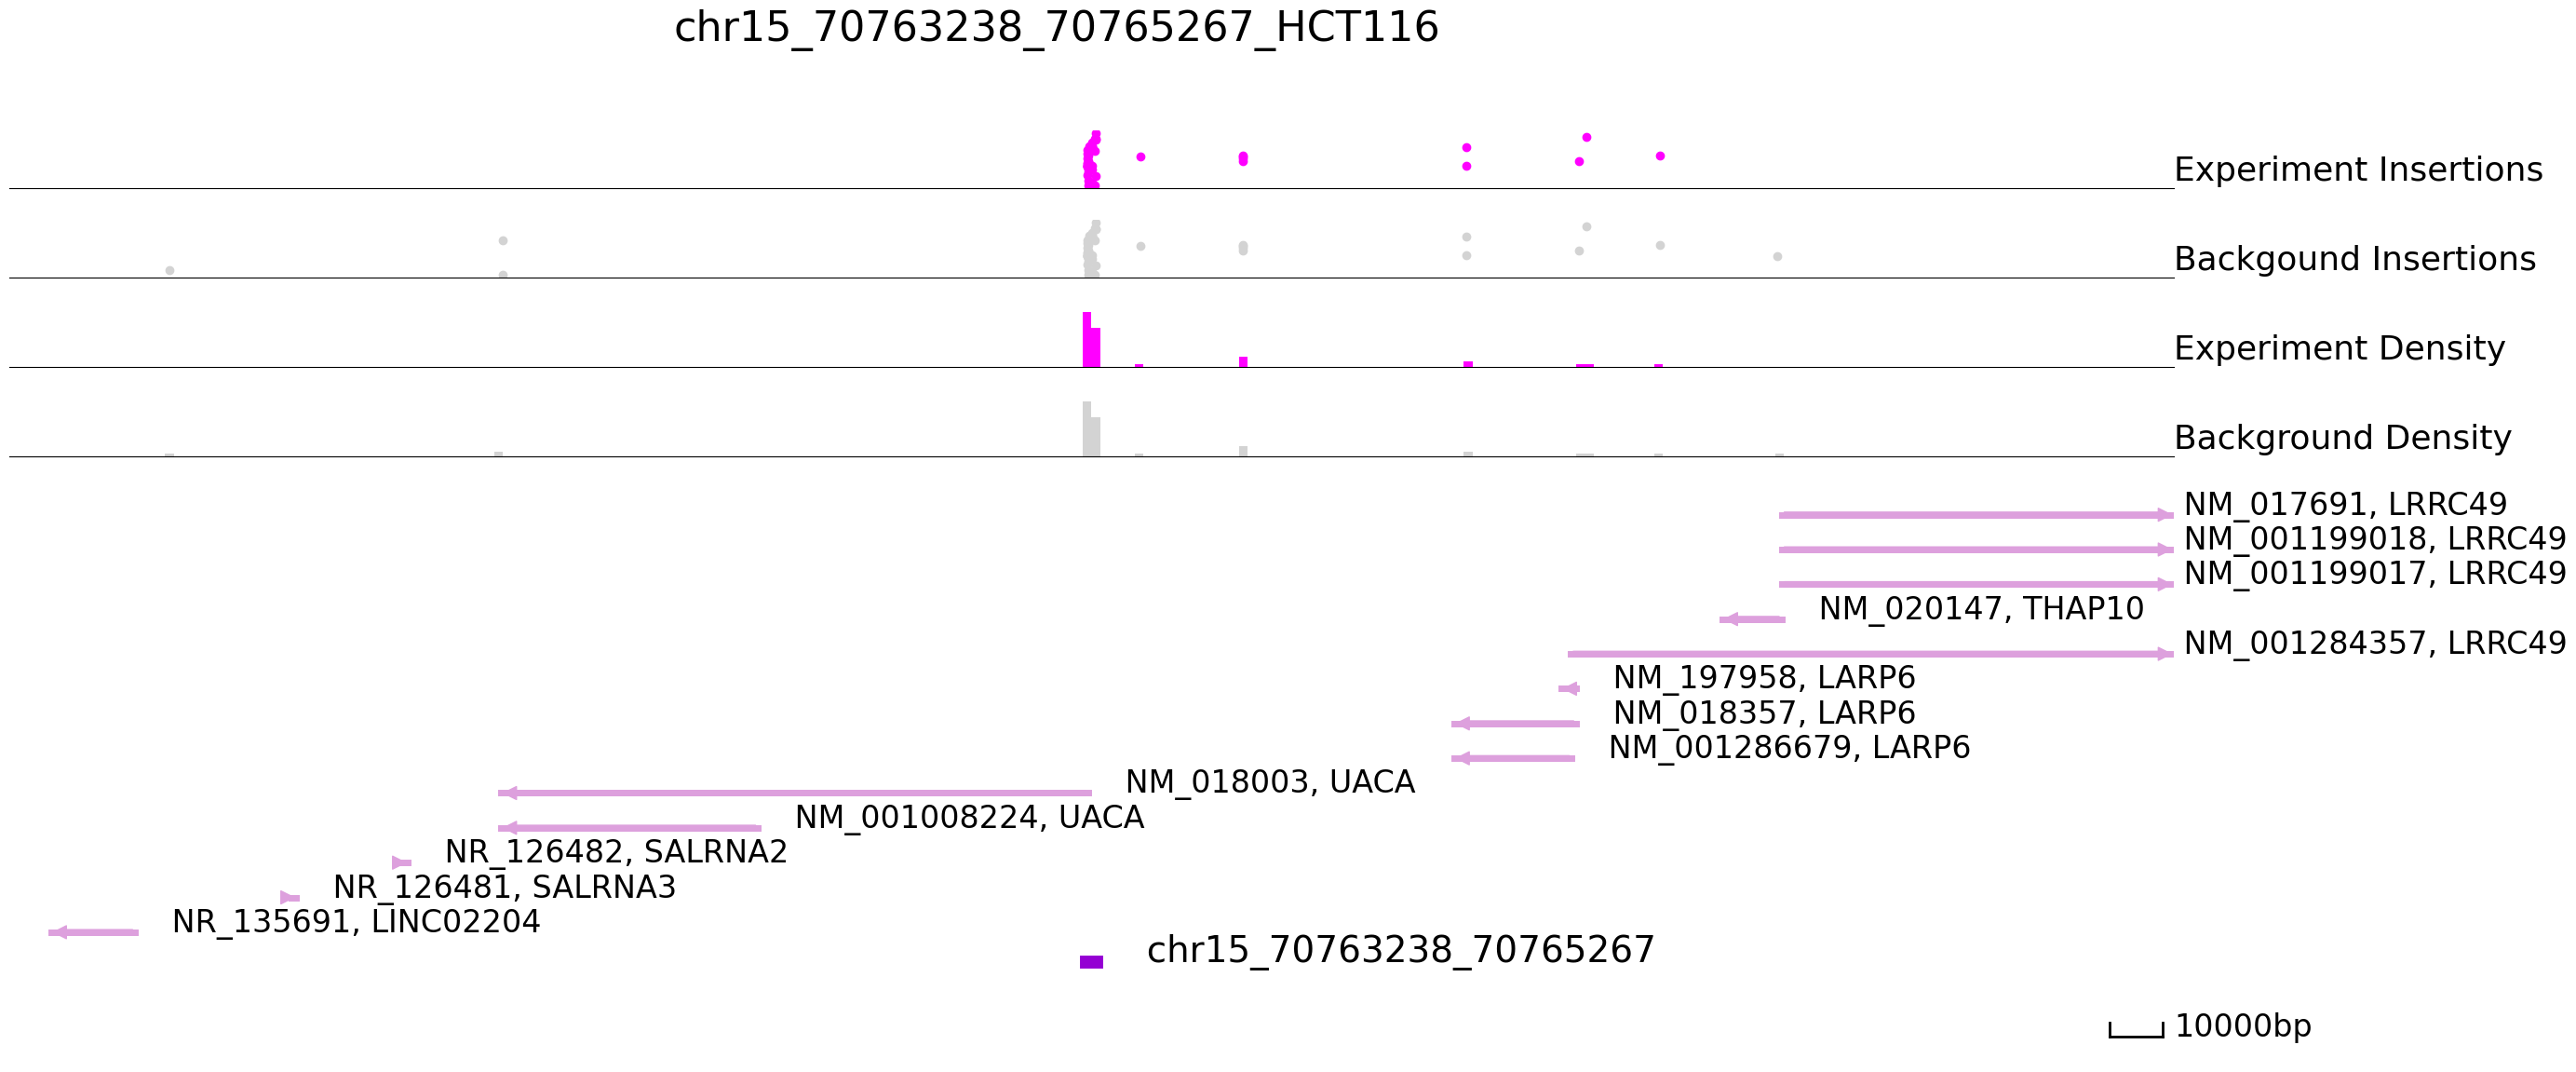

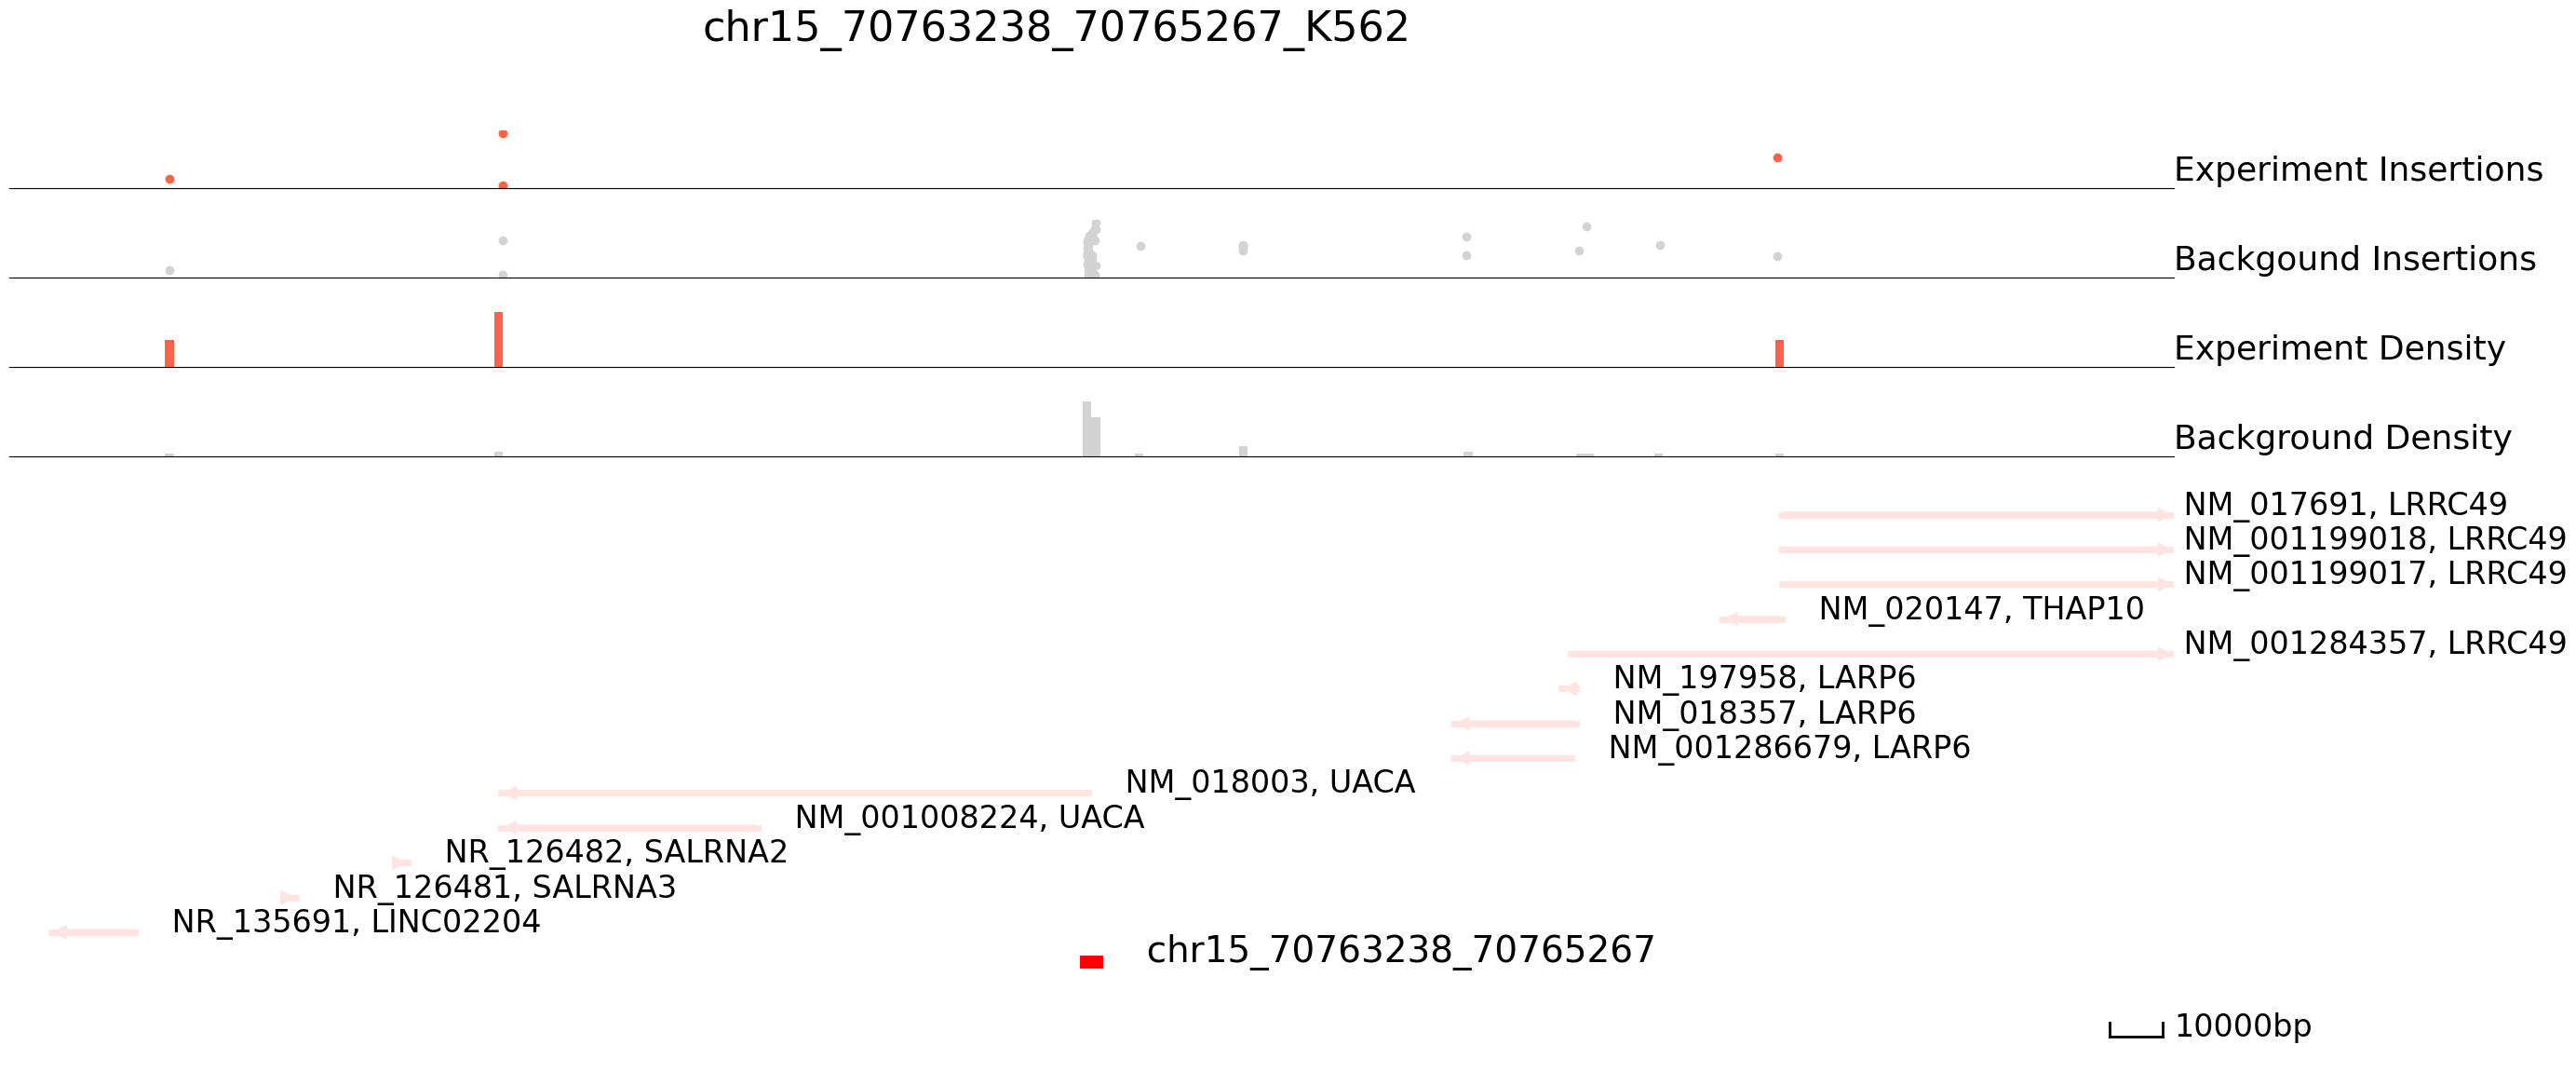

In [33]:
cc.pl.draw_area("chr15", 70763238, 70765267, 200000, peak_data, exp_qbed, "hg38", adata = adata_cc, 
                bins = 250, font_size=2, name = "HCT116", key ='cluster', figsize = (30,13),
                peak_line = 1, color = "purple", plotsize = [1,1,5], title = "chr15_70763238_70765267_HCT116")
cc.pl.draw_area("chr15", 70763238, 70765267, 200000, peak_data, exp_qbed, "hg38", adata = adata_cc,
                bins = 250, font_size=2, name = "K562",key ='cluster', figsize = (30,13),
                peak_line = 1, color = "red", plotsize = [1,1,5], title = "chr15_70763238_70765267_K562")

In the tracks above, we see a strong peak on Chr 15 in HCT116 cell (purple) that is not present in K562 cells (red)

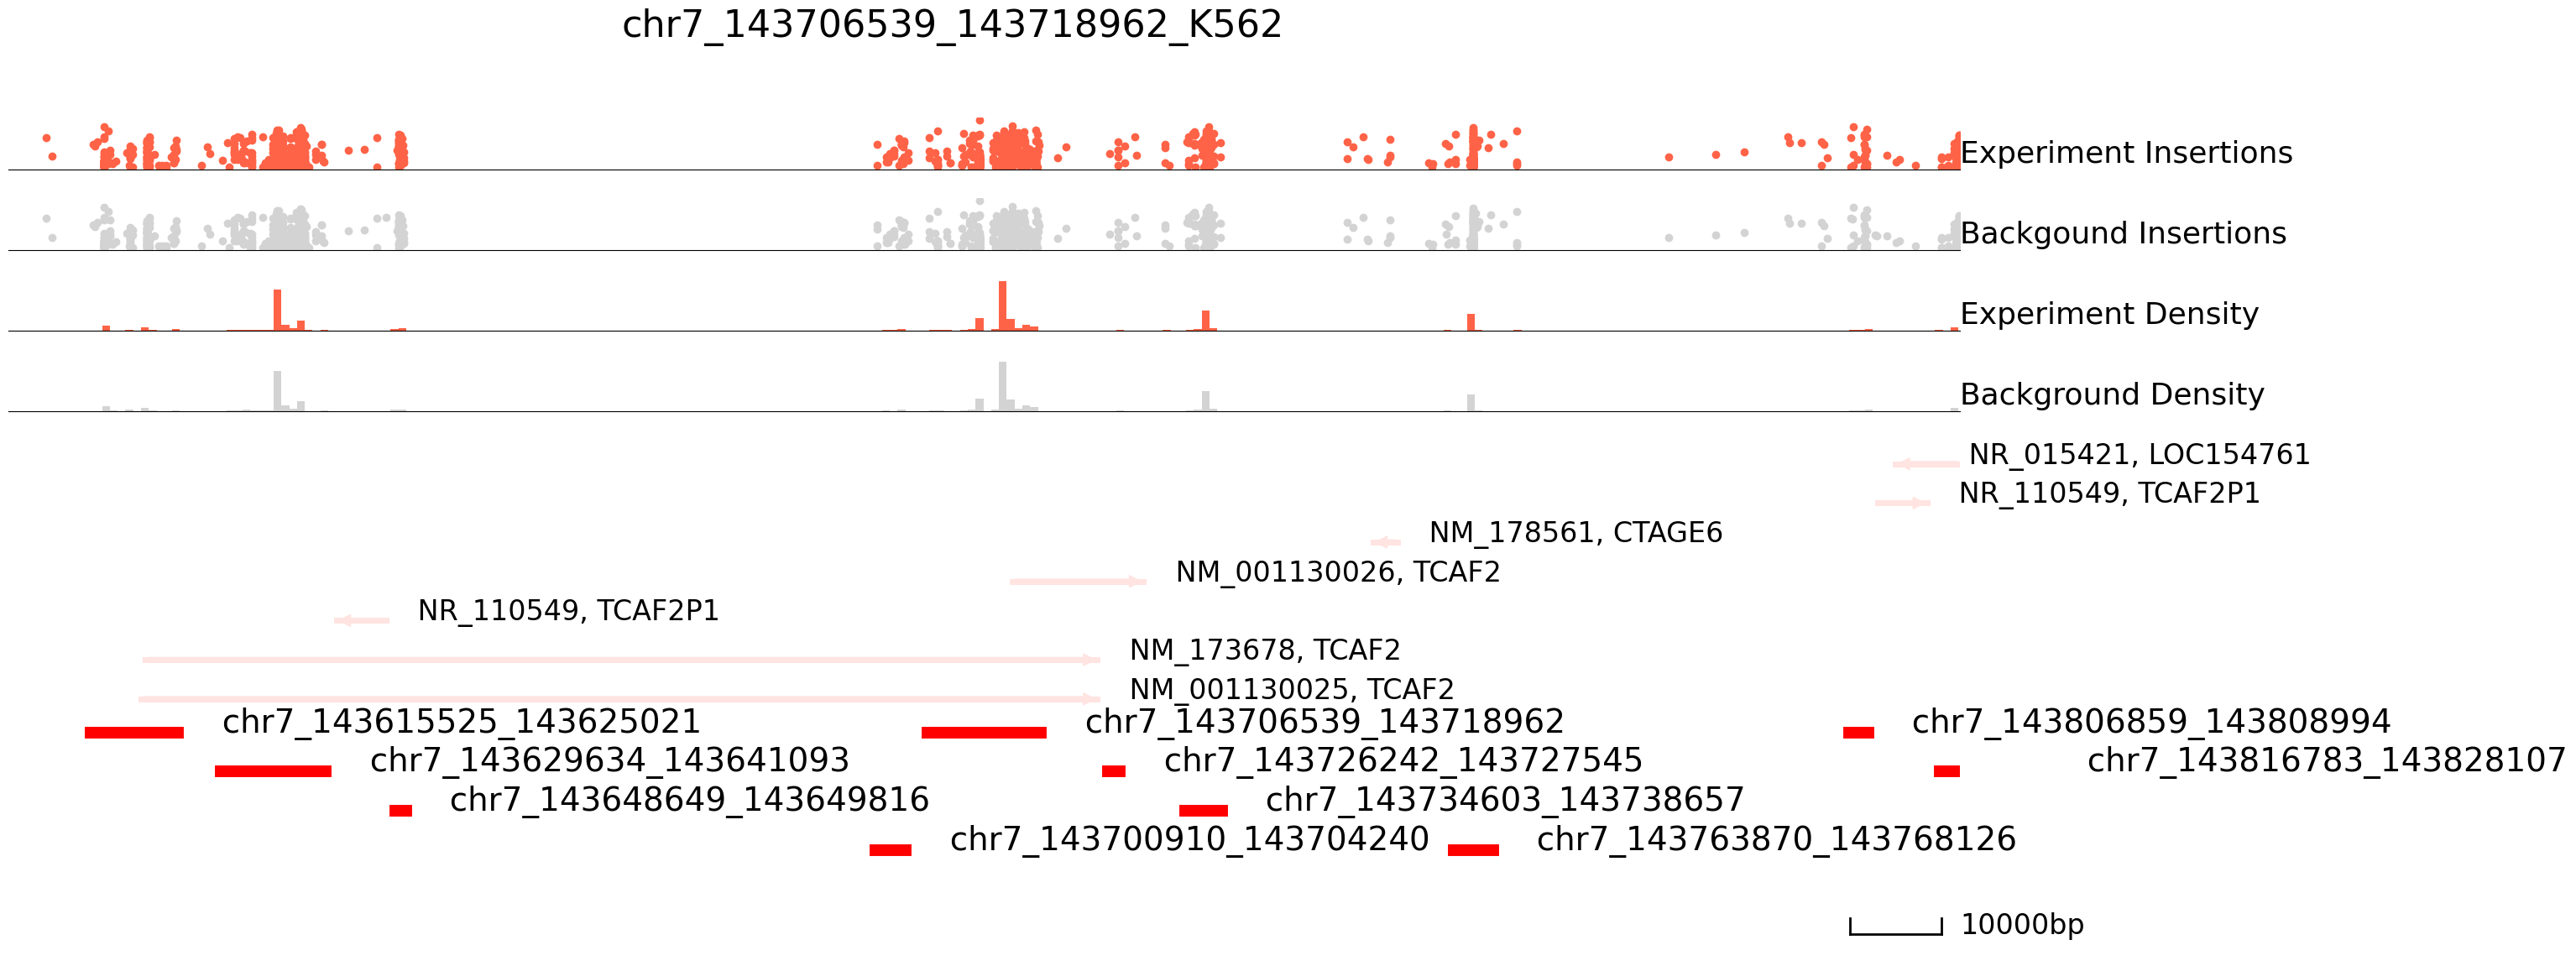

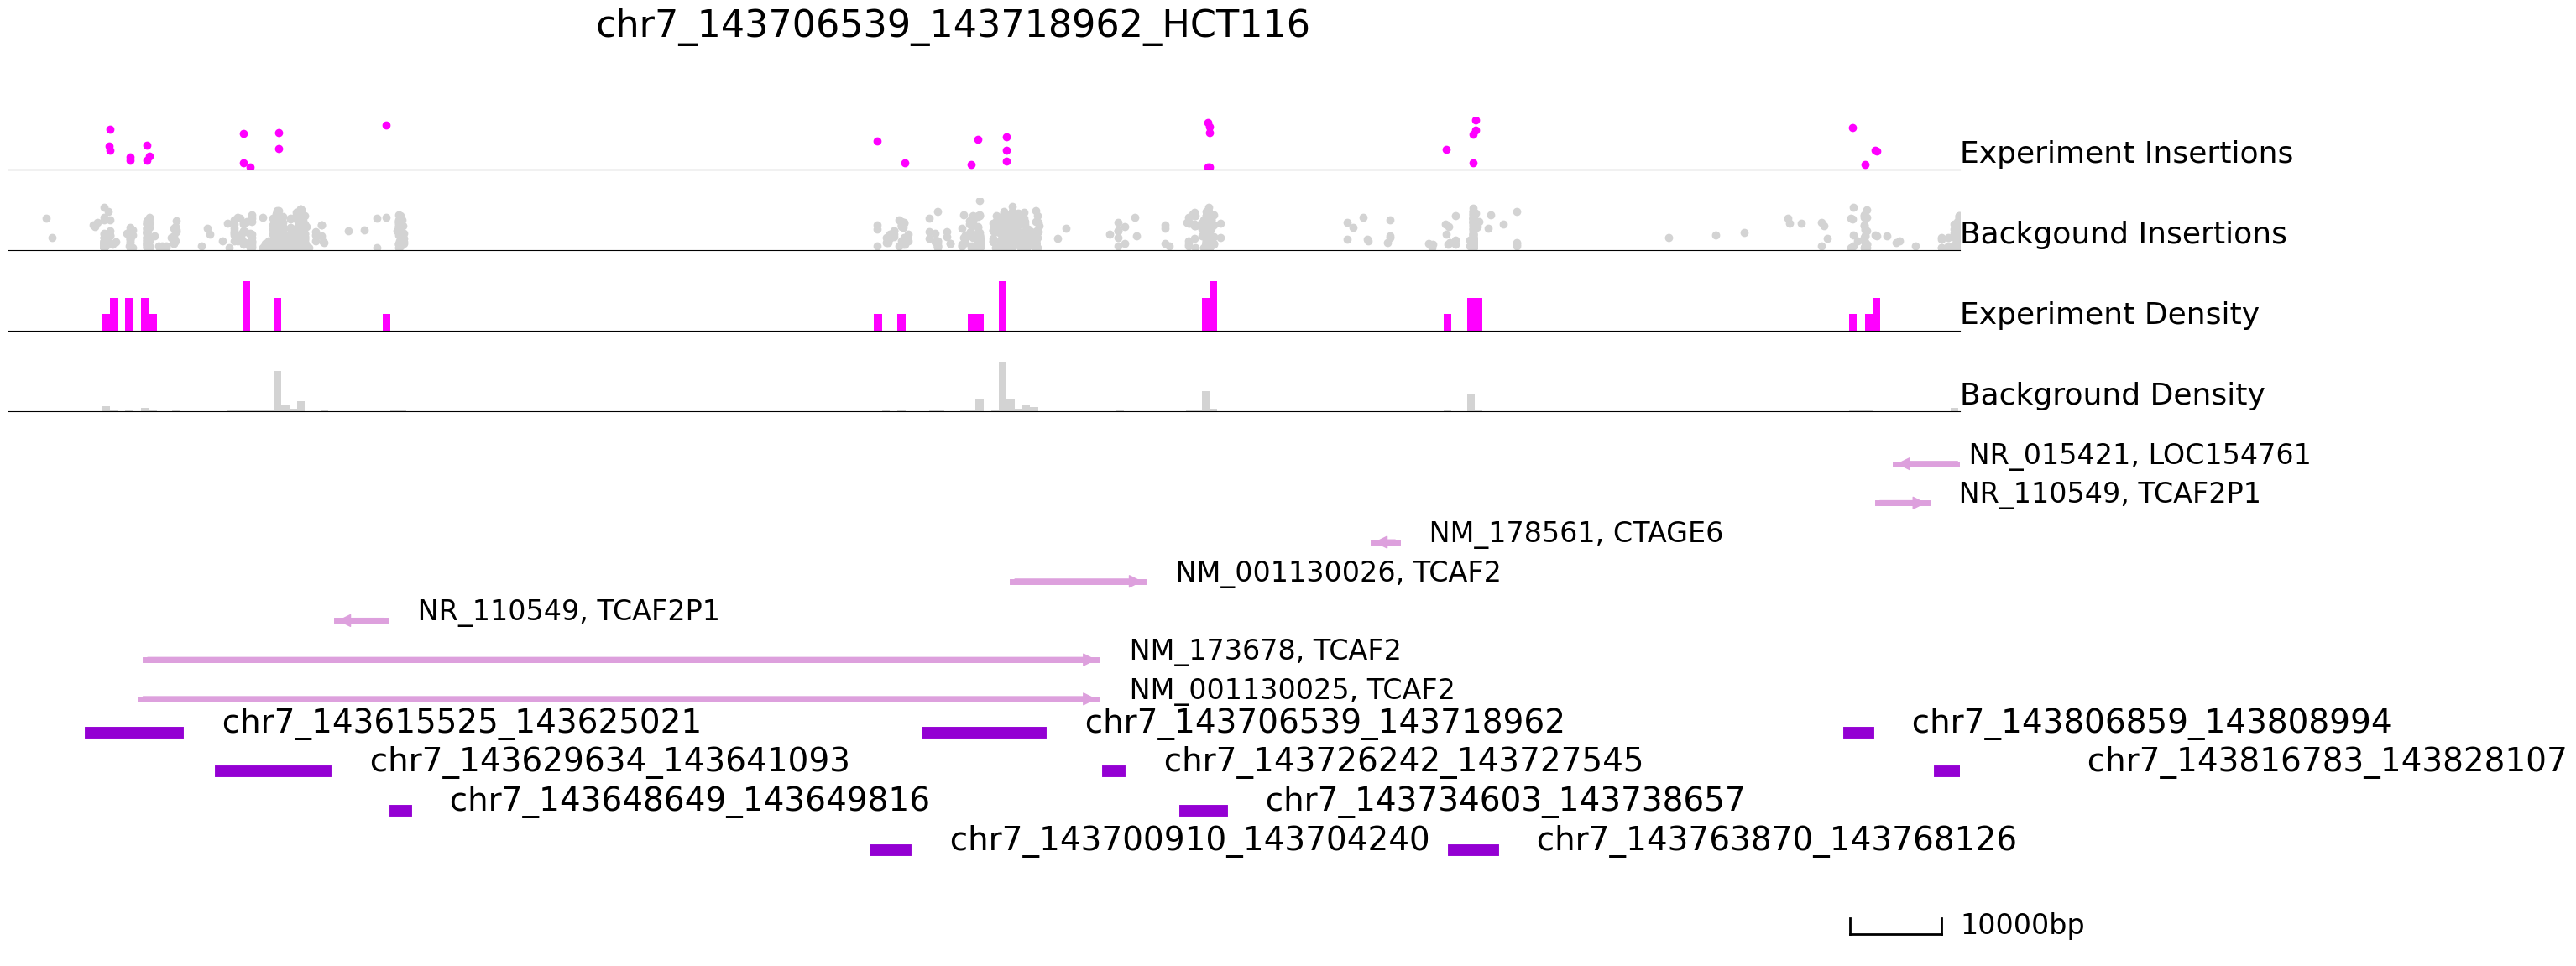

In [34]:
cc.pl.draw_area("chr7", 143706539, 143718962, 100000, peak_data, exp_qbed, "hg38", adata = adata_cc, 
                bins = 250, font_size=2, name = "K562", key = 'cluster', figsize = (30,13),
                peak_line = 4, color = "red", plotsize = [1,1,5], title = "chr7_143706539_143718962_K562")
cc.pl.draw_area("chr7",143706539,143718962,100000,peak_data,exp_qbed,"hg38",adata = adata_cc,  
                bins = 250, font_size=2, name = "HCT116", key ='cluster', figsize = (30,13),
                peak_line = 4, color = "purple", plotsize = [1,1,5], title = "chr7_143706539_143718962_HCT116")

In the tracks above we see a number of Sp1 peaks on chr7 that are tightly bound in K562, but not in HCT116.

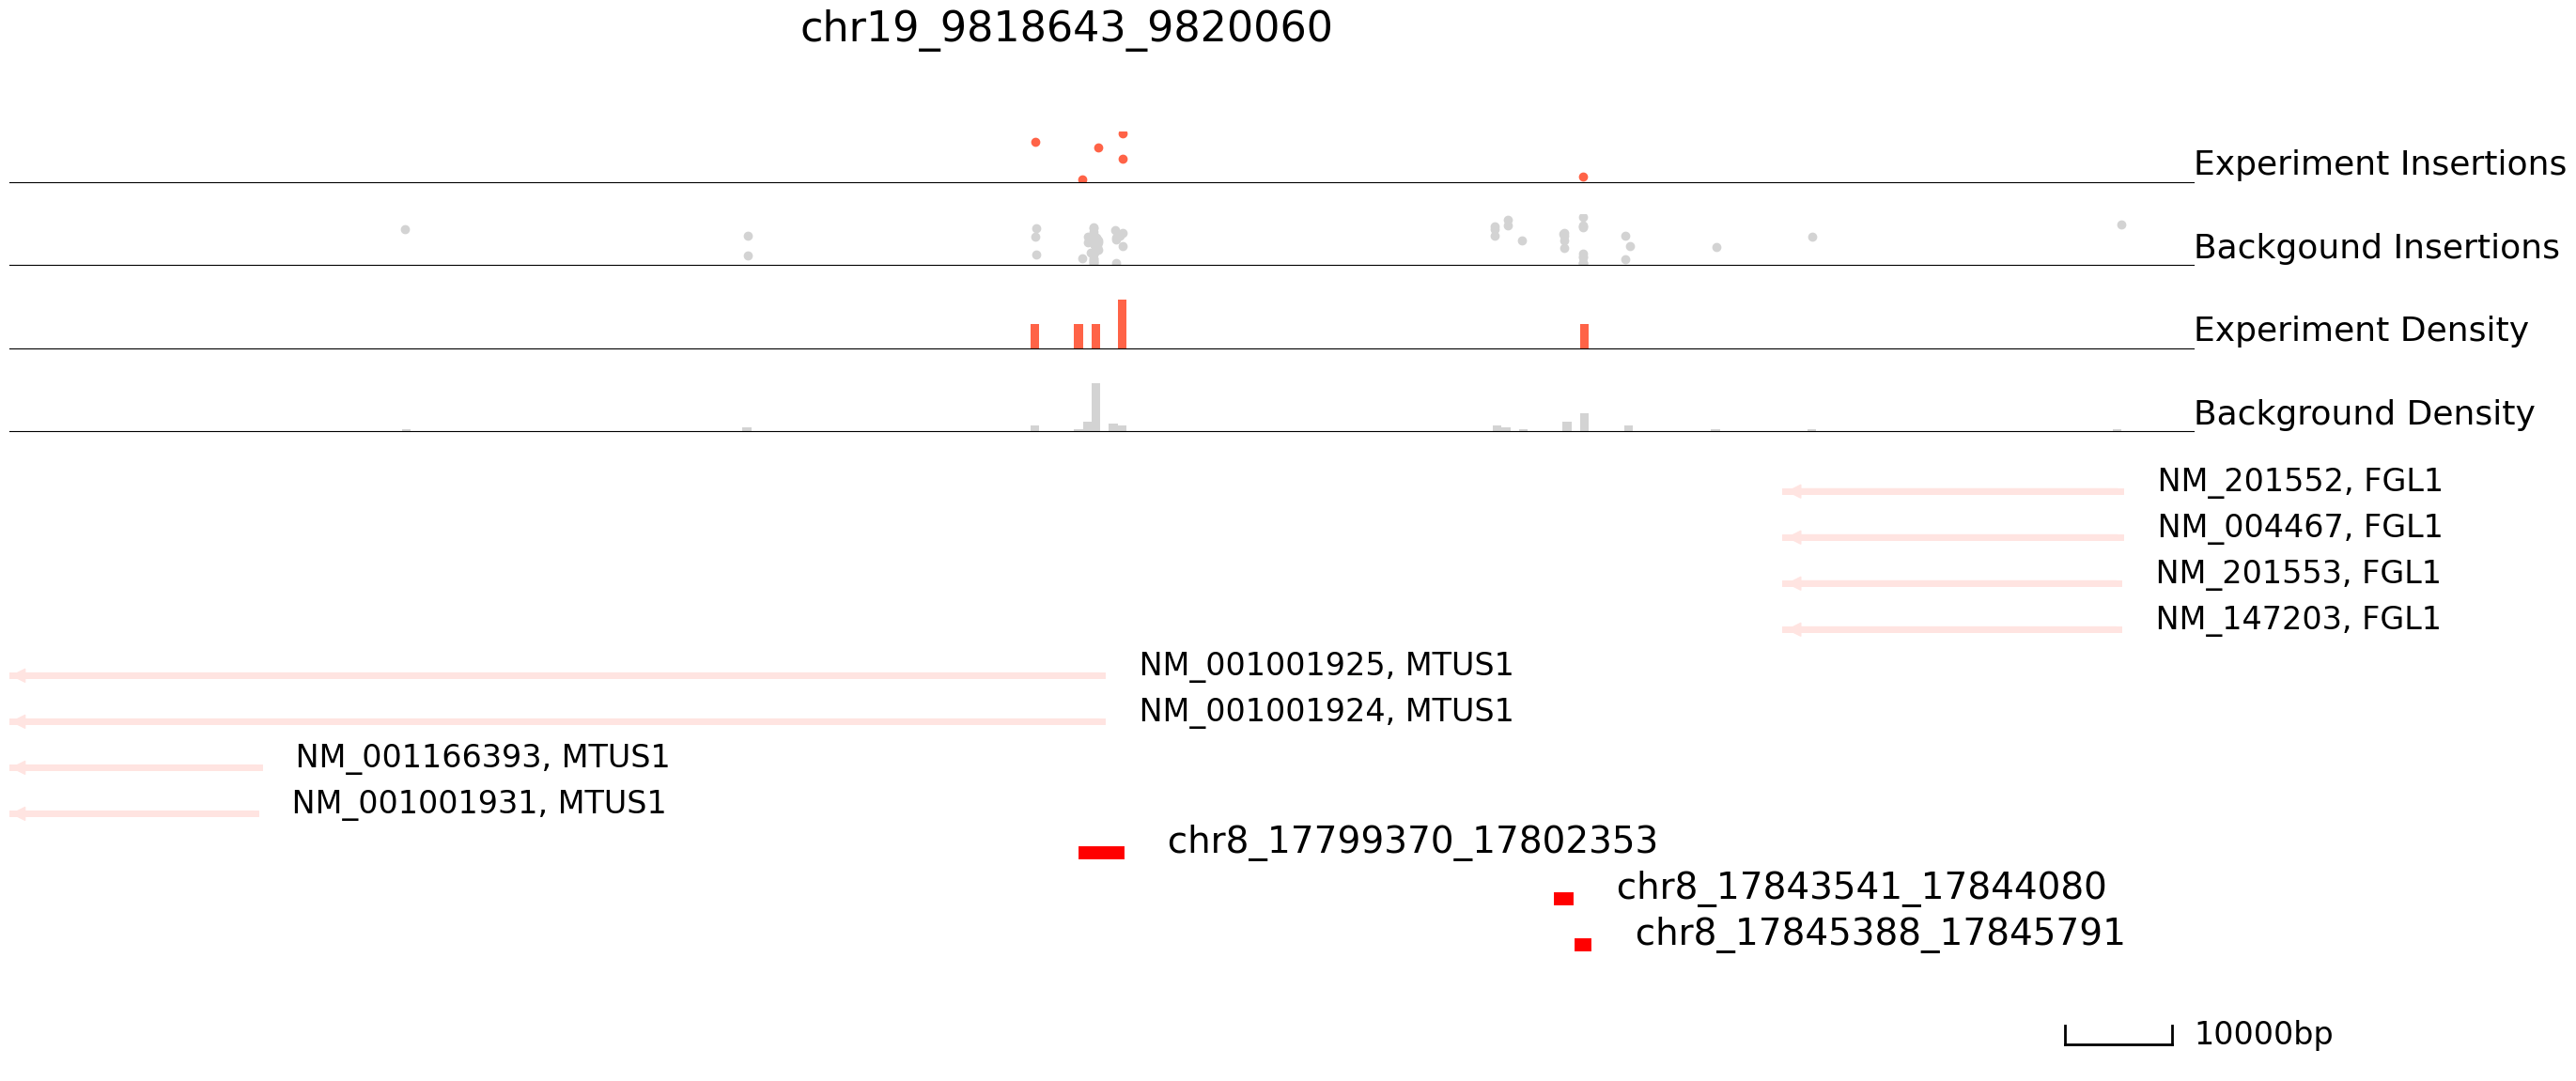

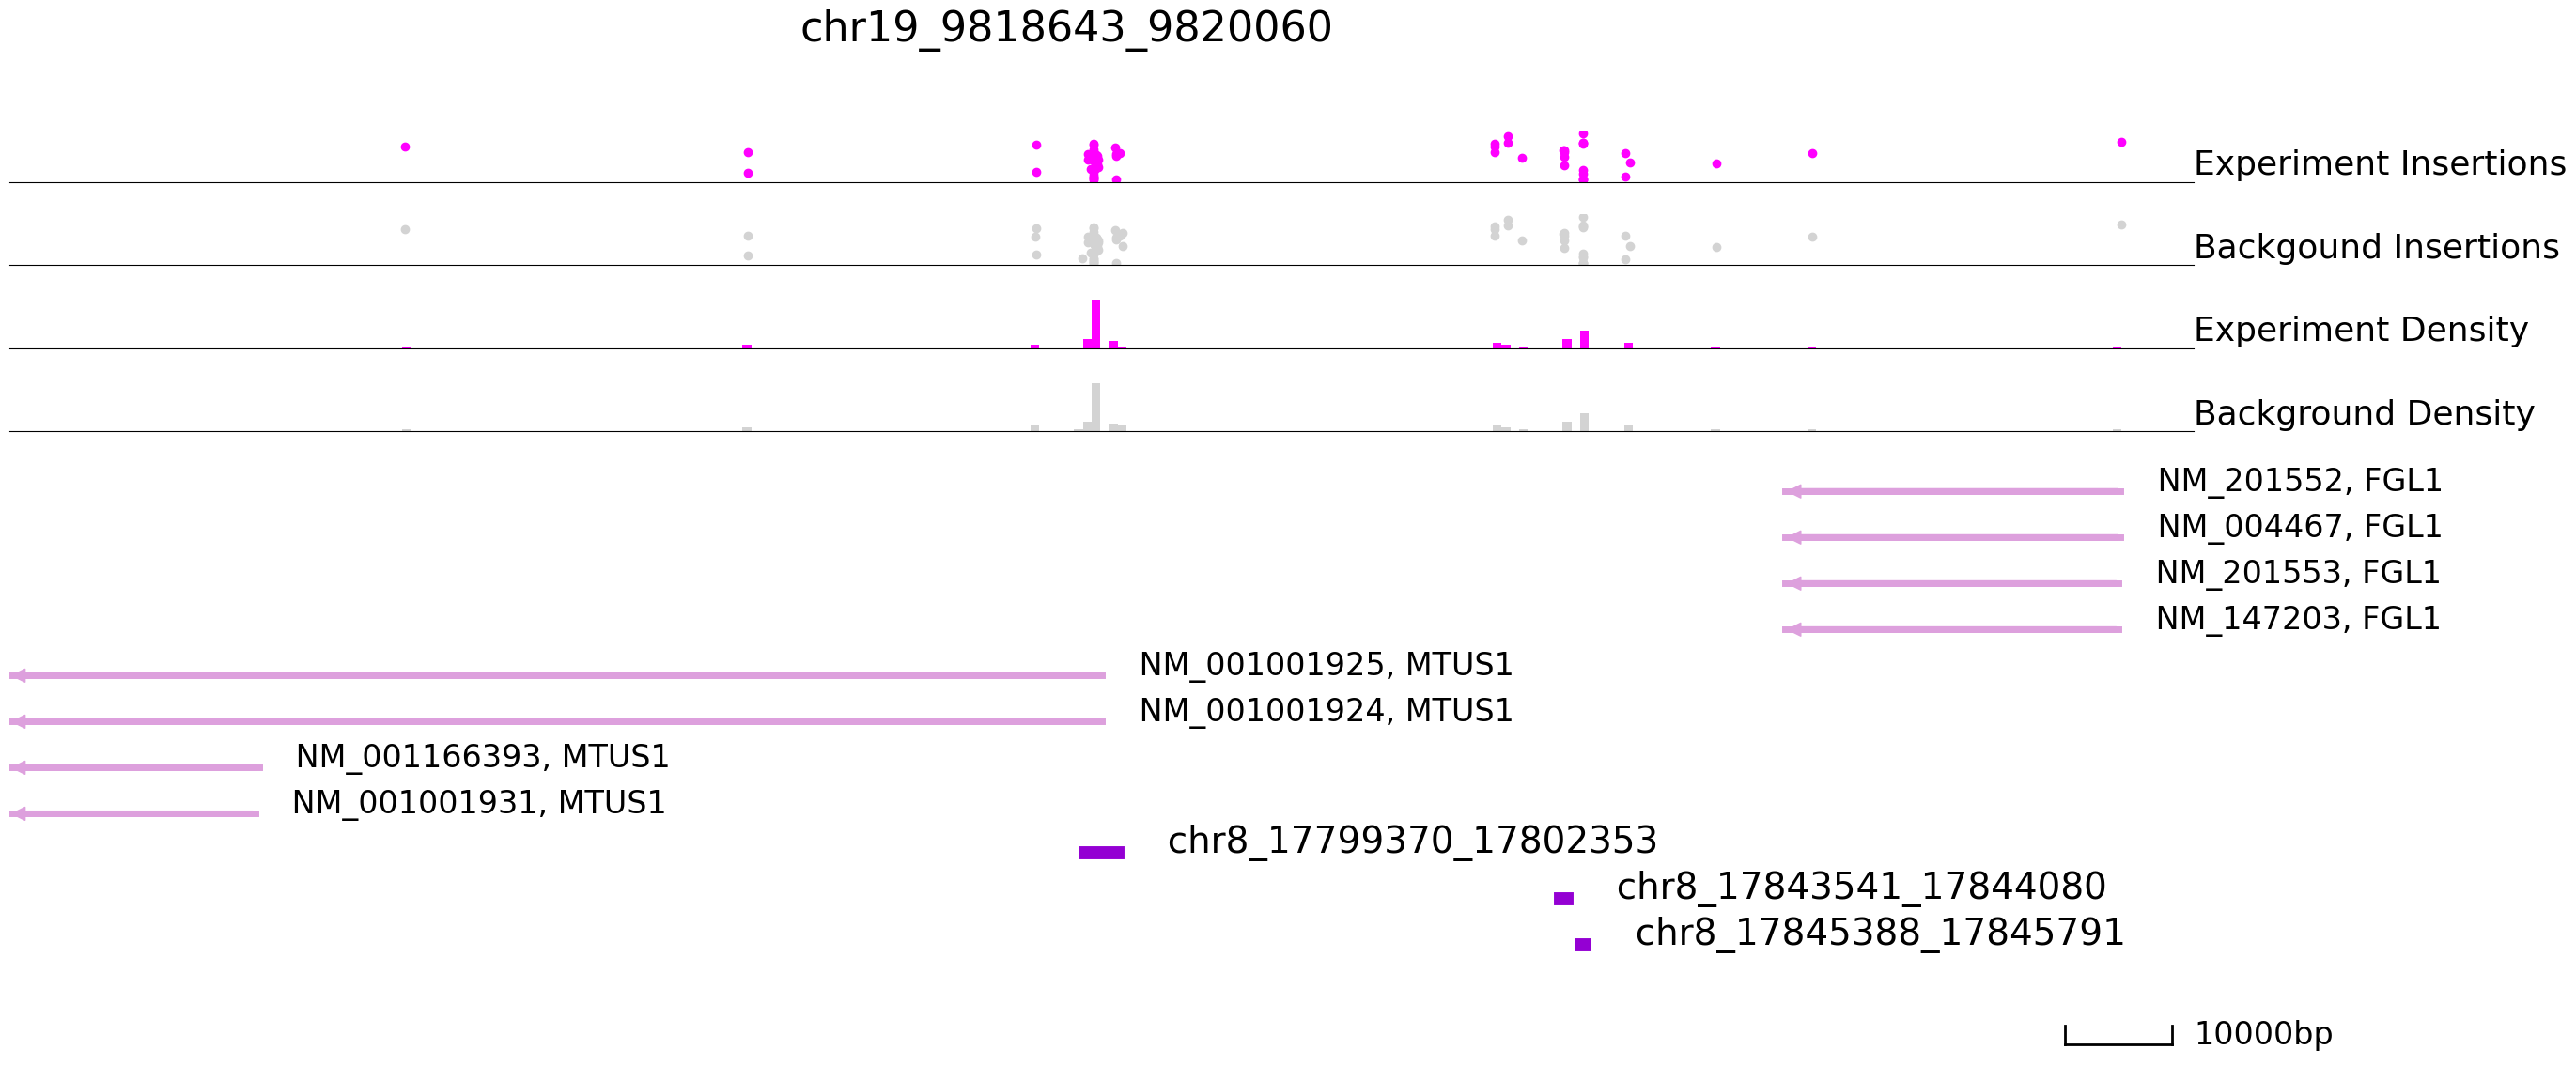

In [35]:
cc.pl.draw_area("chr8", 17799370, 17802353, 100000, peak_data, exp_qbed, "hg38", adata = adata_cc, 
                bins = 250, font_size=2, name = "K562", key = 'cluster', figsize = (30,13), peak_line = 3,
                color = "red", plotsize = [1,1,6], title = "chr19_9818643_9820060")
cc.pl.draw_area("chr8", 17799370, 17802353, 100000, peak_data, exp_qbed, "hg38", adata = adata_cc, 
                bins = 250, font_size=2, name = "HCT116",key ='cluster',figsize = (30,13),peak_line = 3,
                color = "purple", plotsize = [1,1,6], title = "chr19_9818643_9820060")

Here we find peaks on Chr8 that are bound in HCT116 but not in K562 cells.

Saved the file if needed.

In [36]:
adata_cc.write("SP1_qbed.h5ad")